In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

In [2]:
import sklearn
from sklearn.linear_model import LinearRegression
#rom sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LassoLars

from sklearn.linear_model import TweedieRegressor

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
def get_ranks(good_df,ypred):
    cutoff=0.2
    #print (codedata,ypred,ydata)
    #print (len(ypred),len(good_df.mm.to_list()))
    d = {'code':good_df.code.to_list(),'pred':ypred,
         "dockQ":good_df.dockQ.to_list(),"params":good_df.params.to_list(),
        "mm":good_df.mm.to_list()}
    res_df=pd.DataFrame(d).sort_values("pred")
    #res_df.sort_values("CODE")

    i=0
    sumdiff=0
    mmdiff=0
    correct=0
    for code in res_df.code.unique():
        topranked=res_df.loc[res_df.code==code].sort_values("pred")["dockQ"][-1:].max()
        best=res_df.loc[res_df.code==code]["dockQ"].max()
        mmtop=res_df.loc[res_df.code==code].sort_values("pred")["mm"][-1:].max()
        mmbest=res_df.loc[res_df.code==code]["mm"].max()
        #print (code,topranked,best)
        if best>cutoff:
            i+=1
            sumdiff+=best-topranked
            mmdiff+=mmbest-mmtop
            if topranked>cutoff:
                correct+=1
    #print (i,correct,round(sumdiff/i,3))            
    return (i,correct,sumdiff,mmdiff)

In [4]:
reg = LinearRegression()
#reg=RandomForestClassifier(n_estimators=10)
#reg=LassoLars(alpha=.1)
#reg = TweedieRegressor(power=1, alpha=0.5, link='log')
#reg=TheilSenRegressor(random_state=42)
#reg=RANSACRegressor(random_state=42)
#reg=HuberRegressor()

In [5]:
df=pd.read_csv("~/Downloads/summary.csv",sep=",")
df=df.dropna()

In [6]:
sns.set(style="whitegrid")

In [7]:
df["name"]
df.keys()

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'cdhit',
       'dockQ', 'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long',
       'med', 'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA',
       'longB', 'medB', 'longPPVB', 'medPPVB', 'short', 'shortPPV', 'shortA',
       'shortPPVA', 'shortB', 'shortPPVB', 'shortpdb', 'medpdb', 'longpdb',
       'avprob', 'auc', 'evalue', 'seqid', 'rank'],
      dtype='object')

In [8]:

df["code"]=df["name"].str[:4]
df["CODE"]=df["code"]
df["params"]=df["JHparams"]

In [9]:
r=re.compile("^PDB|^pdb|^TMd|gramm")
datasets=df.JHparams.unique()
notRosettaset=list(filter(r.match, datasets))
df2=df.loc[~df.JHparams.isin(notRosettaset)].copy()
df2.JHparams="trRosetta"
df2.params="trRosetta"
df2

name   JHparams  lenA  lenB     msa      msaA      msaB  \
0      1ay7_u1_A-1ay7_u2_A  trRosetta    97    90  1060.0    1485.0    2034.0   
1      1ay7_u2_A-1ay7_u1_A  trRosetta    90    97  1060.0    2034.0    1485.0   
2      1b27_u1_A-1b27_u2_A  trRosetta   109    90   733.0    1484.0    2034.0   
3      1b27_u2_A-1b27_u1_A  trRosetta    90   109   733.0    2034.0    1484.0   
4      1bdj_u1_A-1bdj_u2_A  trRosetta   129   118  5651.0  349880.0   23051.0   
...                    ...        ...   ...   ...     ...       ...       ...   
11209  4y5o_u1_A-4y5o_u2_A  trRosetta    94    85    34.0    3100.0    1781.0   
11210  4zfr_u1_A-4zfr_u2_A  trRosetta   186    77    12.0    9290.0   38386.0   
11211  5brr_u1_A-5brr_u2_A  trRosetta   378   266   107.0   13553.0   45450.0   
11212  5cec_u1_A-5cec_u2_A  trRosetta   403   191     7.0   30621.0  309307.0   
11213  5eg3_u1_A-5eg3_u2_A  trRosetta   303   105     7.0  565997.0   25926.0   

        cdhit  dockQ   fnat  ...  medpdb  longpdb  avprob   auc  evalue  \
0      1026.0  0.298  0.222  ...   178.0    828.0   0.108  0.40  9999.0   
1       989.0  0.239  0.250  ...   188.0    771.0   0.112  0.36  9999.0   
2       654.0  0.223  0.120  ...   187.0    838.0   0.096  0.46     4.3   
3       656.0  0.229  0.160  ...   219.0    922.0   0.099  0.46     4.3   
4      5071.0  0.000  0.000  ...   157.0   1028.0   0.020  0.00  9999.0   
...       ...    ...    ...  ...     ...      ...     ...   ...     ...   
11209    11.0  0.055  0.000  ...    75.0    570.0   0.136  0.00  9999.0   
11210    12.0  0.048  0.000  ...   158.0    615.0   0.160  0.09  9999.0   
11211    79.0  0.009  0.000  ...   332.0   2118.0   0.195  0.00   236.0   
11212     7.0  0.011  0.000  ...   412.0   2031.0   0.220  0.00   197.0   
11213     5.0  0.003  0.000  ...   221.0    893.0   0.149  0.00    68.0   

        seqid  rank  code  CODE     params  
0       0.000   1.0  1ay7  1ay7  trRosetta  
1       0.000   2.0  1ay7  1ay7  trRosetta  
2      50.000   1.0  1b27  1b27  trRosetta  
3      50.000   2.0  1b27  1b27  trRosetta  
4       0.000   1.0  1bdj  1bdj  trRosetta  
...       ...   ...   ...   ...        ...  
11209   0.000   1.0  4y5o  4y5o  trRosetta  
11210   0.000   1.0  4zfr  4zfr  trRosetta  
11211  66.667   1.0  5brr  5brr  trRosetta  
11212  33.333   1.0  5cec  5cec  trRosetta  
11213  40.000   1.0  5eg3  5eg3  trRosetta  

[4732 rows x 45 columns]

In [10]:
df=pd.concat([df,df2], ignore_index=True,sort=False)
df.fillna(0)
df.JHparams.unique()

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-multimerged', '-N 1 -E 1.e-10 --cpu 8 ',
       'N1-top1000-merged', 'N1-top1000', 'N1-top100', 'N1-top2000',
       'N1-top500', 'N3dock', '-N 3 --incE 1.e-2', 'N3-merged',
       'N3-multimerged', 'N3-newdockA', 'N3-newdockB', 'N3-newdockC',
       'N5-newdockA', 'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8',
       'pdbconfold', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4',
       'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting',
       'PDBNEWDOCK-A--step1', 'PD

In [11]:
r=re.compile("^PDB|^pdb")
datasets=df.JHparams.unique()
pdbset=list(filter(r.match, datasets))
df2=df.loc[(df.JHparams.isin(pdbset))&(~df.JHparams.isin(["pdbconfold"]))].copy()
df2.JHparams="PDB"
df2.params="PDB"
df2

name JHparams  lenA  lenB     msa      msaA  \
7444               1ay7_u1_A-1ay7_u2_A      PDB    97    90  1060.0    1485.0   
7445               1b27_u1_A-1b27_u2_A      PDB   109    90   733.0    1484.0   
7446               1bdj_u1_A-1bdj_u2_A      PDB   129   118  5651.0  349880.0   
7447               1bdj_u2_A-1bdj_u1_A      PDB   118   129  5651.0   23051.0   
7448               1bvn_u1_A-1bvn_u2_A      PDB   496    75    95.0   52623.0   
...                                ...      ...   ...   ...     ...       ...   
9720  4k0v_u1_A-4k0v_u2_A.pdb-starting      PDB   424   218     0.0       0.0   
9721  4rf0_u1_A-4rf0_u2_A.pdb-starting      PDB   320    77     0.0       0.0   
9722     4rf0_u1_A-4rf0_u2_A.pdb-step1      PDB   320    77     0.0       0.0   
9723  4xhu_u1_A-4xhu_u2_A.pdb-starting      PDB   352    95     0.0       0.0   
9724     4xhu_u1_A-4xhu_u2_A.pdb-step1      PDB   352    95     0.0       0.0   

          msaB   cdhit  dockQ   fnat  ...  medpdb  longpdb  avprob   auc  \
7444    2034.0   986.0  0.888  0.861  ...     0.0      0.0     0.0  0.02   
7445    2034.0   654.0  0.813  0.700  ...     0.0      0.0     0.0  0.02   
7446   23051.0  5071.0  0.729  0.765  ...     0.0      0.0     0.0  0.01   
7447  349880.0  5080.0  0.060  0.118  ...     0.0      0.0     0.0  0.07   
7448     123.0    85.0  0.076  0.154  ...     0.0      0.0     0.0  0.05   
...        ...     ...    ...    ...  ...     ...      ...     ...   ...   
9720       0.0     0.0  0.000  0.000  ...     0.0      0.0     0.0  0.08   
9721       0.0     0.0  0.000  0.000  ...     0.0      0.0     0.0  0.05   
9722       0.0     0.0  0.220  0.556  ...     0.0      0.0     0.0  0.05   
9723       0.0     0.0  0.000  0.000  ...     0.0      0.0     0.0  0.02   
9724       0.0     0.0  0.169  0.444  ...     0.0      0.0     0.0  0.02   

      evalue   seqid  rank  code  CODE  params  
7444  9999.0   0.000   1.0  1ay7  1ay7     PDB  
7445     4.3  50.000   1.0  1b27  1b27     PDB  
7446  9999.0   0.000   1.0  1bdj  1bdj     PDB  
7447  9999.0   0.000   2.0  1bdj  1bdj     PDB  
7448     2.3  31.250   1.0  1bvn  1bvn     PDB  
...      ...     ...   ...   ...   ...     ...  
9720   144.0  42.857   1.0  4k0v  4k0v     PDB  
9721    51.0  60.000   1.0  4rf0  4rf0     PDB  
9722    51.0  60.000   1.0  4rf0  4rf0     PDB  
9723    17.0  22.222   1.0  4xhu  4xhu     PDB  
9724    17.0  22.222   1.0  4xhu  4xhu     PDB  

[2281 rows x 45 columns]

In [12]:
df=pd.concat([df,df2], ignore_index=True,sort=False)
df.fillna(0)
df.params.unique()

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-multimerged', '-N 1 -E 1.e-10 --cpu 8 ',
       'N1-top1000-merged', 'N1-top1000', 'N1-top100', 'N1-top2000',
       'N1-top500', 'N3dock', '-N 3 --incE 1.e-2', 'N3-merged',
       'N3-multimerged', 'N3-newdockA', 'N3-newdockB', 'N3-newdockC',
       'N5-newdockA', 'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8',
       'pdbconfold', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4',
       'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting',
       'PDBNEWDOCK-A--step1', 'PD

In [13]:
# Add a linear combination of trRosetta
r=re.compile(".*-N.*") # .*cpu.*
datasets=df.JHparams.unique()
JHsets=list(filter(r.match, datasets))



In [14]:
cutoff=0.1
goodmodels=df.loc[(df.dockQ>cutoff)&(df.JHparams.isin(JHsets))].code.unique()
good_df=df.loc[(df.code.isin(goodmodels))&(df.JHparams.isin(JHsets))] #.reset_index()
df.dockQ.dtypes

dtype('float64')

Text(0.5, 1.0, 'CC 0.271 Good: 0.636 Loss: 0.123 , 0.171 Test: 11')

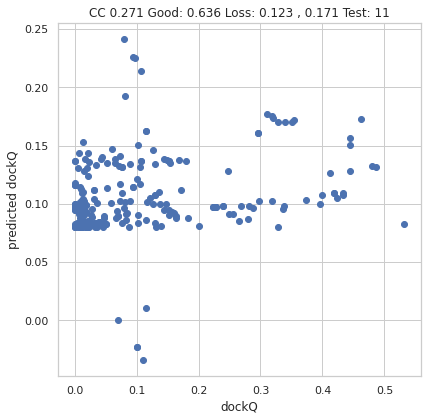

In [15]:
ydata=good_df.dockQ

#cols=["lenA","lenB","msa","long","med","longA","medA","longB","medB","tmA","tmB"]
#xdata=good_df[["lenA","lenB","long","med"]]
#cols=["longA","longB","medA","medB","tmA","tmB"]
cols=["med","long","msa"]
#cols=["msa"]
xdata=good_df[cols]
reg.fit(xdata,ydata)
ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
cc=np.corrcoef(ydata,ypred)
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")
(i,j,dockq,mm)=get_ranks(good_df,ypred)
#print(i,j,k/i)
ax.set_title("CC" + " " + str(round(cc[0,1],3))
            + " Good: " + str(round(j/i,3)) + " Loss: " + str(round(dockq/i,3))
             + " , " + str(round(mm/i,3))
             + " Test: " + str(i)
            )


In [16]:
xdata=df.loc[df.JHparams.isin(JHsets)][cols]
ypred = reg.predict(xdata)
df2=df.loc[df.JHparams.isin(JHsets)].reset_index()
df2.loc[:,'pred'] = ypred
topranked=pd.DataFrame(columns = df2.columns) 


In [17]:

for name in df2.name.unique():
    foo=df2.loc[df2.name==name].sort_values("pred")[-1:].max()
    #print(foo)
    foo_df=pd.DataFrame(foo).transpose()
    #print (foo_df)
    topranked=pd.concat([topranked,foo_df], ignore_index=True)
topranked["JHparams"]="JHranked"
topranked.params="JHranked"
topranked=topranked.drop(["pred","index"],axis=1)
topranked.columns

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'cdhit',
       'dockQ', 'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long',
       'med', 'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA',
       'longB', 'medB', 'longPPVB', 'medPPVB', 'short', 'shortPPV', 'shortA',
       'shortPPVA', 'shortB', 'shortPPVB', 'shortpdb', 'medpdb', 'longpdb',
       'avprob', 'auc', 'evalue', 'seqid', 'rank', 'code', 'CODE', 'params'],
      dtype='object')

In [18]:
df.columns

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'cdhit',
       'dockQ', 'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long',
       'med', 'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA',
       'longB', 'medB', 'longPPVB', 'medPPVB', 'short', 'shortPPV', 'shortA',
       'shortPPVA', 'shortB', 'shortPPVB', 'shortpdb', 'medpdb', 'longpdb',
       'avprob', 'auc', 'evalue', 'seqid', 'rank', 'code', 'CODE', 'params'],
      dtype='object')

In [19]:
df=pd.concat([df,topranked], ignore_index=True,sort=False)
df.fillna(0)
df.params.unique()

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-multimerged', '-N 1 -E 1.e-10 --cpu 8 ',
       'N1-top1000-merged', 'N1-top1000', 'N1-top100', 'N1-top2000',
       'N1-top500', 'N3dock', '-N 3 --incE 1.e-2', 'N3-merged',
       'N3-multimerged', 'N3-newdockA', 'N3-newdockB', 'N3-newdockC',
       'N5-newdockA', 'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8',
       'pdbconfold', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4',
       'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting',
       'PDBNEWDOCK-A--step1', 'PD

In [20]:
df

name      JHparams lenA lenB   msa    msaA    msaB  \
0      1ay7_u1_A-1ay7_u2_A  -N 3 --cpu 8   97   90  1060    1485    2034   
1      1ay7_u2_A-1ay7_u1_A  -N 3 --cpu 8   90   97  1060    2034    1485   
2      1b27_u1_A-1b27_u2_A  -N 3 --cpu 8  109   90   733    1484    2034   
3      1b27_u2_A-1b27_u1_A  -N 3 --cpu 8   90  109   733    2034    1484   
4      1bdj_u1_A-1bdj_u2_A  -N 3 --cpu 8  129  118  5651  349880   23051   
...                    ...           ...  ...  ...   ...     ...     ...   
26502  5cec_u2_A-5cec_u1_A      JHranked  191  403     8   59695     200   
26503  5cra_u1_A-5cra_u2_A      JHranked  193   77     1      11   42026   
26504  5cra_u2_A-5cra_u1_A      JHranked   77  193     1   42026      11   
26505  5eg3_u1_A-5eg3_u2_A      JHranked  303  105   499  560629   26558   
26506  5eg3_u2_A-5eg3_u1_A      JHranked  105  303   305    3955  147816   

      cdhit  dockQ   fnat  ... medpdb longpdb avprob   auc evalue   seqid  \
0      1026  0.298  0.222  ...    178     828  0.108   0.4   9999       0   
1       989  0.239   0.25  ...    188     771  0.112  0.36   9999       0   
2       654  0.223   0.12  ...    187     838  0.096  0.46    4.3      50   
3       656  0.229   0.16  ...    219     922  0.099  0.46    4.3      50   
4      5071      0      0  ...    157    1028   0.02     0   9999       0   
...     ...    ...    ...  ...    ...     ...    ...   ...    ...     ...   
26502     7   0.05  0.075  ...   1039    4734  0.226     0    197  33.333   
26503     1  0.008      0  ...    148     595  0.179     0   9999       0   
26504     1  0.103      0  ...    417    2052  0.181  0.17   9999       0   
26505   278      0      0  ...    221     893  0.046     0     68      40   
26506   102  0.012      0  ...    645    3089  0.098     0     68      40   

      rank  code  CODE        params  
0        1  1ay7  1ay7  -N 3 --cpu 8  
1        2  1ay7  1ay7  -N 3 --cpu 8  
2        1  1b27  1b27  -N 3 --cpu 8  
3        2  1b27  1b27  -N 3 --cpu 8  
4        1  1bdj  1bdj  -N 3 --cpu 8  
...    ...   ...   ...           ...  
26502    2  5cec  5cec      JHranked  
26503    1  5cra  5cra      JHranked  
26504    2  5cra  5cra      JHranked  
26505    1  5eg3  5eg3      JHranked  
26506    2  5eg3  5eg3      JHranked  

[26507 rows x 45 columns]

In [21]:
#df["rank"].str.isnumeric().unique()
#df.dtypes

In [22]:
# We need to check that everything is numeric
cols=['name', 'JHparams', 'seqid',      'rank']

#for d in df.columns.values.tolist():
for d in ["rank","len"]:
    if d=="name": continue
    if d=="JHparams": continue
    print (d)
    #print (df.loc[(df[d].str.isnumeric()!=True)][cols+[d]])
    #print (df.loc[(df[d].str.isnumeric()][d].unique()
    #print (df[d].str.isnumeric().unique())

rank
len


In [23]:
# Divide data into datasets


df["tmAB"]=df[["tmA","tmB"]].mean(axis=1)
df["msaAB"]=df[["msaA","msaB"]].mean(axis=1)
df["tmAB_max"]=df[["tmA","tmB"]].max(axis=1)
df["msaAB_max"]=df[["msaA","msaB"]].max(axis=1)
df["tmAB_min"]=df[["tmA","tmB"]].min(axis=1)
df["msaAB_min"]=df[["msaA","msaB"]].min(axis=1)
df["numcorrect"]=df["longPPV"]*df["long"]
df["len"]=df["lenA"]+df["lenB"]

codes=df.code.unique()
df_mean=df.groupby(["JHparams","code"]).mean()
df_max=df.groupby(["JHparams","code"]).max()
df_min=df.groupby(["JHparams","code"]).min()
df_first=df.loc[df["rank"]==1]

In [24]:
df.columns.values.tolist()

['name',
 'JHparams',
 'lenA',
 'lenB',
 'msa',
 'msaA',
 'msaB',
 'cdhit',
 'dockQ',
 'fnat',
 'iRMS',
 'LRMS',
 'fnonnat',
 'mm',
 'tmA',
 'tmB',
 'long',
 'med',
 'longPPV',
 'medPPV',
 'longA',
 'medA',
 'longPPVA',
 'medPPVA',
 'longB',
 'medB',
 'longPPVB',
 'medPPVB',
 'short',
 'shortPPV',
 'shortA',
 'shortPPVA',
 'shortB',
 'shortPPVB',
 'shortpdb',
 'medpdb',
 'longpdb',
 'avprob',
 'auc',
 'evalue',
 'seqid',
 'rank',
 'code',
 'CODE',
 'params',
 'tmAB',
 'msaAB',
 'tmAB_max',
 'msaAB_max',
 'tmAB_min',
 'msaAB_min',
 'numcorrect',
 'len']

In [25]:
cols=['name', 'JHparams', 'seqid',      'rank']
      
d="TMdock-nohomology"
#df.loc[df.JHparams==d].groupby(["code"])[cols].first()

df.loc[(df.JHparams==d) & ((df["rank"].str.isnumeric()!=True))][cols]
#df.loc[(df.JHparams==d)]["rank"].str.isnumeric()
#df.loc[(df.JHparams==d)] 
      
      

AttributeError: Can only use .str accessor with string values!

In [26]:
datasets=df.JHparams.unique()
data_mean={}
data_max={}
data_min={}
for d in datasets:
    print (d)
    data_mean[d]=df.loc[df.JHparams==d].groupby(["code"]).mean()
    data_max[d]=df.loc[df.JHparams==d].groupby(["code"]).max()
    data_min[d]=df.loc[df.JHparams==d].groupby(["code"]).min()


-N 3 --cpu 8


confold


gramm


homodimer


ispred


-N 1 -E 1.e-100 --cpu 8


-N 1 -E 1.e-2 


N1-merged-pdb


N1-merged


N1-N3-multimerged


-N 1 -E 1.e-10 --cpu 8 


N1-top1000-merged


N1-top1000


N1-top100


N1-top2000


N1-top500


N3dock


-N 3 --incE 1.e-2


N3-merged


N3-multimerged


N3-newdockA


N3-newdockB


N3-newdockC


N5-newdockA


N5-newdockB


N5-newdockC


-N 5 --cpu 8


pdbconfold


pdbcontacts


PDBDOCK2


PDBDOCK3


PDBDOCK4


PDBDOCK


PDBNEWDOCK-standard


PDBNEWDOCK-standard--starting


PDBNEWDOCK-standard--step1


pdbnewcontacts


PDBNEWDOCK-A--dockB1


PDBNEWDOCK-A--dockB2


PDBNEWDOCK-A--dockB-relax


PDBNEWDOCK-A--dockC1


PDBNEWDOCK-A--dockC2


PDBNEWDOCK-A--dockC-relax


PDBNEWDOCK-A--dockD1


PDBNEWDOCK-A--dockD2


PDBNEWDOCK-A--dockD-relax


PDBNEWDOCK-A--starting


PDBNEWDOCK-A--step1


PDBNEWDOCK-B--dockB1


PDBNEWDOCK-B--dockB2


PDBNEWDOCK-B--dockB-relax


PDBNEWDOCK-B--dockC1


PDBNEWDOCK-B--dockC2


PDBNEWDOCK-B--dockC-relax


PDBNEWDOCK-B--dockD1


PDBNEWDOCK-B--dockD2


PDBNEWDOCK-B--dockD-relax


PDBNEWDOCK-B--starting


PDBNEWDOCK-B--step1


PDBNEWDOCK-C--dockB1


PDBNEWDOCK-C--dockB2


PDBNEWDOCK-C--dockB-relax


PDBNEWDOCK-C--dockC1


PDBNEWDOCK-C--dockC2


PDBNEWDOCK-C--dockC-relax


PDBNEWDOCK-C--dockD1


PDBNEWDOCK-C--dockD2


PDBNEWDOCK-C--dockD-relax


PDBNEWDOCK-C--starting


PDBNEWDOCK-C--step1


PDBNEWDOCK-D--dockB1


PDBNEWDOCK-D--dockB2


PDBNEWDOCK-D--dockB-relax


PDBNEWDOCK-D--dockC1


PDBNEWDOCK-D--dockC2


PDBNEWDOCK-D--dockC-relax


PDBNEWDOCK-D--dockD1


PDBNEWDOCK-D--dockD2


PDBNEWDOCK-D--dockD-relax


PDBNEWDOCK-D--starting


PDBNEWDOCK-D--step1


PDBNEWDOCK-repulsion--starting


PDBNEWDOCK-repulsion--step1


rbh-jh


rbh-merged-pdb


rbh-merged


rbh


TMdock-nohomology-1.e-5


TMdock-double


TMdock-nohomology


TMdock


trRosetta


PDB


JHranked


In [27]:
df.loc[ (df.JHparams=="trRosetta")  & (df["rank"]==1)]

name   JHparams lenA lenB   msa    msaA    msaB cdhit  \
19058  1ay7_u1_A-1ay7_u2_A  trRosetta   97   90  1060    1485    2034  1026   
19060  1b27_u1_A-1b27_u2_A  trRosetta  109   90   733    1484    2034   654   
19062  1bdj_u1_A-1bdj_u2_A  trRosetta  129  118  5651  349880   23051  5071   
19064  1buh_u1_A-1buh_u2_A  trRosetta  291   72  1177  555226    1820   548   
19066  1bvn_u1_A-1bvn_u2_A  trRosetta  496   75    95   52623     123    85   
...                    ...        ...  ...  ...   ...     ...     ...   ...   
23785  4y5o_u1_A-4y5o_u2_A  trRosetta   94   85    34    3100    1781    11   
23786  4zfr_u1_A-4zfr_u2_A  trRosetta  186   77    12    9290   38386    12   
23787  5brr_u1_A-5brr_u2_A  trRosetta  378  266   107   13553   45450    79   
23788  5cec_u1_A-5cec_u2_A  trRosetta  403  191     7   30621  309307     7   
23789  5eg3_u1_A-5eg3_u2_A  trRosetta  303  105     7  565997   25926     5   

       dockQ   fnat  ...  CODE     params      tmAB     msaAB tmAB_max  \
19058  0.298  0.222  ...  1ay7  trRosetta  0.828190    1759.5  0.84625   
19060  0.223   0.12  ...  1b27  trRosetta  0.824750    1759.0  0.85428   
19062      0      0  ...  1bdj  trRosetta  0.861435  186465.5  0.92240   
19064      0      0  ...  1buh  trRosetta  0.560760  278523.0  0.73259   
19066  0.006      0  ...  1bvn  trRosetta  0.619740   26373.0  0.70905   
...      ...    ...  ...   ...        ...       ...       ...      ...   
23785  0.055      0  ...  4y5o  trRosetta  0.568465    2440.5  0.71099   
23786  0.048      0  ...  4zfr  trRosetta  0.505235   23838.0  0.64391   
23787  0.009      0  ...  5brr  trRosetta  0.332210   29501.5  0.38444   
23788  0.011      0  ...  5cec  trRosetta  0.508770  169964.0  0.70983   
23789  0.003      0  ...  5eg3  trRosetta  0.358330  295961.5  0.41599   

      msaAB_max tmAB_min msaAB_min numcorrect  len  
19058    2034.0  0.81013    1485.0     53.985  187  
19060    2034.0  0.79522    1484.0     49.025  199  
19062  349880.0  0.80047   23051.0          0  247  
19064  555226.0  0.38893    1820.0          0  363  
19066   52623.0  0.53043     123.0          0  571  
...         ...      ...       ...        ...  ...  
23785    3100.0  0.42594    1781.0          0  179  
23786   38386.0  0.36656    9290.0          3  263  
23787   45450.0  0.27998   13553.0        468  644  
23788  309307.0  0.30771   30621.0      2.006  594  
23789  565997.0  0.30067   25926.0          0  408  

[2667 rows x 53 columns]

In [28]:
df.JHparams.unique()

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-multimerged', '-N 1 -E 1.e-10 --cpu 8 ',
       'N1-top1000-merged', 'N1-top1000', 'N1-top100', 'N1-top2000',
       'N1-top500', 'N3dock', '-N 3 --incE 1.e-2', 'N3-merged',
       'N3-multimerged', 'N3-newdockA', 'N3-newdockB', 'N3-newdockC',
       'N5-newdockA', 'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8',
       'pdbconfold', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4',
       'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting',
       'PDBNEWDOCK-A--step1', 'PD

In [29]:
data_first={}
data_second={}
for d in datasets:
    data_first[d]=df.loc[ (df["JHparams"]==d)  & (df["rank"]==1)]
    data_second[d]=df.loc[ (df["JHparams"]==d)  & (df["rank"]==2)]
data_first[datasets[1]]

name JHparams lenA lenB msa msaA msaB cdhit  dockQ   fnat  \
436  1ay7_u1_A-1ay7_u2_A  confold   97   90   0    0    0     0  0.337    0.5   
441  1b27_u1_A-1b27_u2_A  confold  109   90   0    0    0     0  0.056   0.04   
446  1bvn_u1_A-1bvn_u2_A  confold  496   75   0    0    0     0   0.01      0   
451  1dfj_u1_A-1dfj_u2_A  confold  457  125   0    0    0     0  0.016  0.011   
456  1gcq_u1_A-1gcq_u2_A  confold   66   57   0    0    0     0  0.022      0   
..                   ...      ...  ...  ...  ..  ...  ...   ...    ...    ...   
831  4txv_u1_A-4txv_u2_A  confold  177  139   0    0    0     0   0.01      0   
836  4xhu_u1_A-4xhu_u2_A  confold  352   95   0    0    0     0   0.02      0   
841  4xkl_u1_A-4xkl_u2_A  confold   76   34   0    0    0     0  0.022      0   
846  4xs0_u1_A-4xs0_u2_A  confold  147  141   0    0    0     0  0.098  0.222   
851  5brr_u1_A-5brr_u2_A  confold  378  266   0    0    0     0   0.01      0   

     ...  CODE   params      tmAB msaAB tmAB_max msaAB_max tmAB_min msaAB_min  \
436  ...  1ay7  confold  0.596110   0.0  0.63915       0.0  0.55307       0.0   
441  ...  1b27  confold  0.450565   0.0  0.60440       0.0  0.29673       0.0   
446  ...  1bvn  confold  0.313675   0.0  0.33139       0.0  0.29596       0.0   
451  ...  1dfj  confold  0.302560   0.0  0.34193       0.0  0.26319       0.0   
456  ...  1gcq  confold  0.283870   0.0  0.28721       0.0  0.28053       0.0   
..   ...   ...      ...       ...   ...      ...       ...      ...       ...   
831  ...  4txv  confold  0.572305   0.0  0.59428       0.0  0.55033       0.0   
836  ...  4xhu  confold  0.361400   0.0  0.47265       0.0  0.25015       0.0   
841  ...  4xkl  confold  0.356220   0.0  0.51666       0.0  0.19578       0.0   
846  ...  4xs0  confold  0.638185   0.0  0.64247       0.0  0.63390       0.0   
851  ...  5brr  confold  0.389945   0.0  0.47396       0.0  0.30593       0.0   

    numcorrect  len  
436     53.985  187  
441     49.025  199  
446          0  571  
451          0  582  
456      71.76  123  
..         ...  ...  
831          0  316  
836          0  447  
841          0  110  
846    224.928  288  
851          2  644  

[84 rows x 53 columns]

In [30]:
datasets


array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-multimerged', '-N 1 -E 1.e-10 --cpu 8 ',
       'N1-top1000-merged', 'N1-top1000', 'N1-top100', 'N1-top2000',
       'N1-top500', 'N3dock', '-N 3 --incE 1.e-2', 'N3-merged',
       'N3-multimerged', 'N3-newdockA', 'N3-newdockB', 'N3-newdockC',
       'N5-newdockA', 'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8',
       'pdbconfold', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4',
       'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting',
       'PDBNEWDOCK-A--step1', 'PD

In [31]:
df_merged = pd.merge(data_first[datasets[0]],data_first[d], on=['code'],how="inner")
df_max

name  lenA  lenB     msa  \
JHparams                code                                            
-N 1 -E 1.e-10 --cpu 8  1ay7  1ay7_u2_A-1ay7_u1_A    97    97     2.0   
                        1b27  1b27_u2_A-1b27_u1_A   109   109    35.0   
                        1bdj  1bdj_u2_A-1bdj_u1_A   129   129   201.0   
                        1buh  1buh_u2_A-1buh_u1_A   291   291   899.0   
                        1bvn  1bvn_u2_A-1bvn_u1_A   496   496     7.0   
...                                           ...   ...   ...     ...   
trRosetta               4zfr  4zfr_u2_A-4zfr_u1_A   186   186  1358.0   
                        5brr  5brr_u2_A-5brr_u1_A   378   378   611.0   
                        5cec  5cec_u2_A-5cec_u1_A   403   403  1594.0   
                        5cra  5cra_u2_A-5cra_u1_A   193   193     1.0   
                        5eg3  5eg3_u2_A-5eg3_u1_A   303   303   499.0   

                                  msaA      msaB   cdhit  dockQ   fnat  \
JHparams                code                                             
-N 1 -E 1.e-10 --cpu 8  1ay7     960.0     960.0     2.0  0.023  0.000   
                        1b27     272.0     272.0    34.0  0.019  0.000   
                        1bdj   29395.0   29395.0   124.0  0.024  0.000   
                        1buh  255874.0  255874.0   401.0  0.061  0.000   
                        1bvn    2041.0    2041.0     7.0  0.038  0.000   
...                                ...       ...     ...    ...    ...   
trRosetta               4zfr   42037.0   42037.0   504.0  0.048  0.000   
                        5brr   45636.0   45970.0   550.0  0.035  0.073   
                        5cec  312612.0  312612.0  1577.0  0.050  0.075   
                        5cra   42026.0   42026.0     1.0  0.103  0.000   
                        5eg3  565997.0  565997.0   279.0  0.016  0.000   

                                 iRMS  ...  CODE                   params  \
JHparams                code           ...                                  
-N 1 -E 1.e-10 --cpu 8  1ay7   15.615  ...  1ay7  -N 1 -E 1.e-10 --cpu 8    
                        1b27   99.396  ...  1b27  -N 1 -E 1.e-10 --cpu 8    
                        1bdj   17.785  ...  1bdj  -N 1 -E 1.e-10 --cpu 8    
                        1buh  491.316  ...  1buh  -N 1 -E 1.e-10 --cpu 8    
                        1bvn   19.311  ...  1bvn  -N 1 -E 1.e-10 --cpu 8    
...                               ...  ...   ...                      ...   
trRosetta               4zfr  291.376  ...  4zfr                trRosetta   
                        5brr  642.702  ...  5brr                trRosetta   
                        5cec  732.223  ...  5cec                trRosetta   
                        5cra   22.323  ...  5cra                trRosetta   
                        5eg3  542.531  ...  5eg3                trRosetta   

                                  tmAB     msaAB  tmAB_max  msaAB_max  \
JHparams                code                                            
-N 1 -E 1.e-10 --cpu 8  1ay7  0.468725     503.0   0.56969      960.0   
                        1b27  0.662735     158.0   0.66638      272.0   
                        1bdj  0.824210   14815.0   0.84941    29395.0   
                        1buh  0.650535  128775.0   0.72158   255874.0   
                        1bvn  0.313205    1023.5   0.33372     2041.0   
...                                ...       ...       ...        ...   
trRosetta               4zfr  0.862735   28229.0   0.90969    42037.0   
                        5brr  0.848585   29785.0   0.97832    45970.0   
                        5cec  0.782885  172839.5   0.86787   312612.0   
                        5cra  0.694590   21018.5   0.91652    42026.0   
                        5eg3  0.833605  295961.5   0.86145   565997.0   

                              tmAB_min  msaAB_min  numcorrect  len  
JHparams                code                                        
-N 1 -E 1.e-10 --cpu 8  1ay7   0.36776    

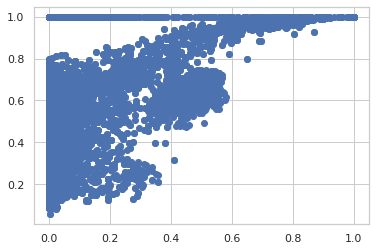

In [32]:

plt.scatter(df.dockQ,df.mm)


Text(0, 0.5, 'TM trRosetta')

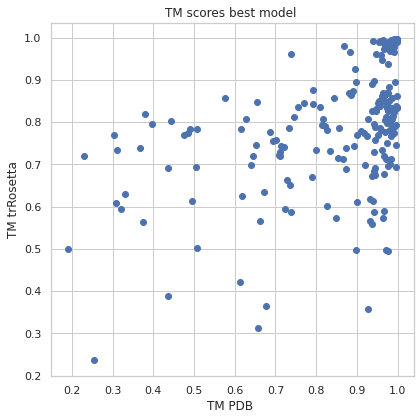

In [33]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
df_merged = pd.merge(data_max["PDB"],data_max["trRosetta"], on=['code'],how="inner")
plt.scatter(df_merged.tmAB_x,df_merged.tmAB_y,label=d)
ax.set_title("TM scores best model ")
ax.set_xlabel("TM PDB ")
ax.set_ylabel("TM trRosetta")



Text(0, 0.5, 'dockQ')

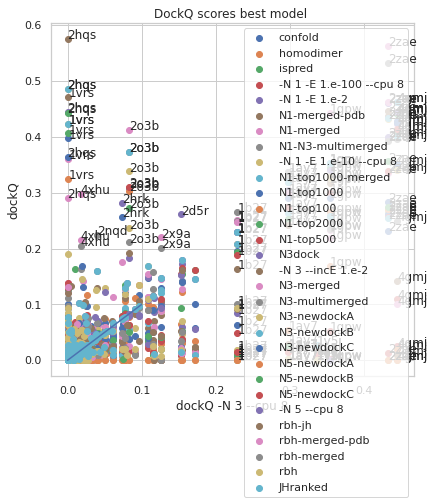

In [34]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
    if d=="trRosetta":continue   
    #if d=="confold":continue   
    #if d=="rbh-merged-pdb":continue   

    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4] # +d
        except:
            sstr=df_merged.name_y[i][0:4] #+d
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.1]
y=[0,0.1]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores best model ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'numcorrect')

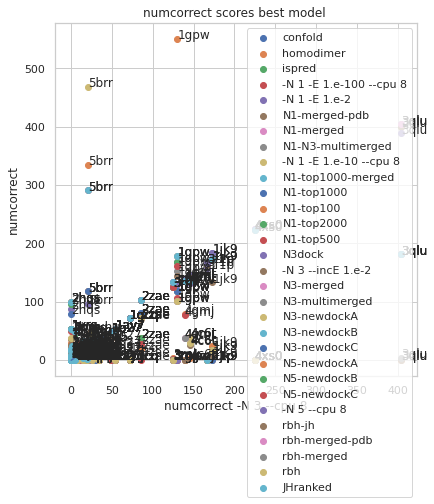

In [35]:
cutoff=5
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue 
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
        
    #if d=="confold":continue   
    #if d=="rbh-merged-pdb":continue   

    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.numcorrect_x,df_merged.numcorrect_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.numcorrect_x[i]> cutoff or df_merged.numcorrect_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.numcorrect_x[i], df_merged.numcorrect_y[i]))
x=[0,50]
y=[0,50]
plt.plot(x,y)
ax.legend()
ax.set_title("numcorrect scores best model ")
ax.set_xlabel("numcorrect "+str(datasets[0]))
ax.set_ylabel("numcorrect")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ')

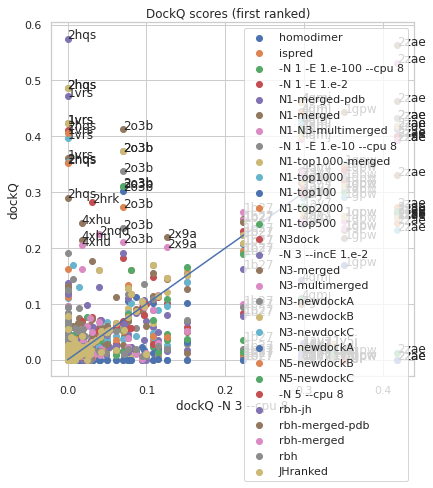

In [36]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue   
    if d=="confold":continue   
    #if d=="rbh-merged-pdb":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first[datasets[0]],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.3]
y=[0,0.3]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first ranked)  ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ')

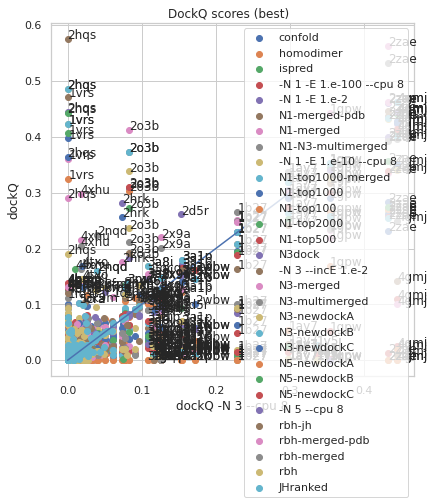

In [37]:
cutoff=0.1
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue   
    if d=="rbh merge pdb ":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
        
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.3]
y=[0,0.3]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ')

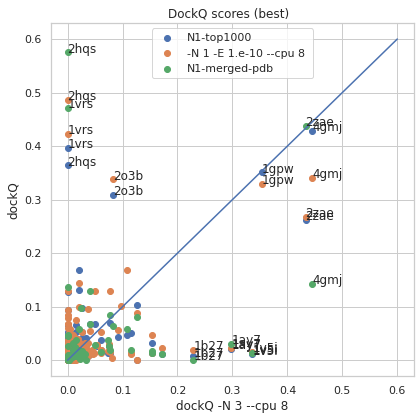

In [38]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["N1-top1000","-N 1 -E 1.e-10 --cpu 8 ","N1-merged-pdb"]:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue   
    if d=="rbh merge pdb ":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
        
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.6]
y=[0,0.6]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [39]:
data_max.keys()

dict_keys(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred', '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb', 'N1-merged', 'N1-N3-multimerged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock', '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8', 'pdbconfold', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B--dockB1', 'PDBNEWDOCK-B--dockB2', 'PDBNEWDOCK-B--dockB-relax', 'PDBNEWDOCK-B--dockC1', 'PD

Text(0, 0.5, 'dockQ trRosetta')

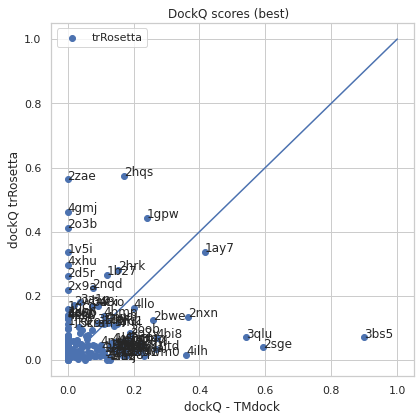

In [40]:
cutoff=0.1
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["TMdock-double"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ - TMdock")
ax.set_ylabel("dockQ "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ trRosetta')

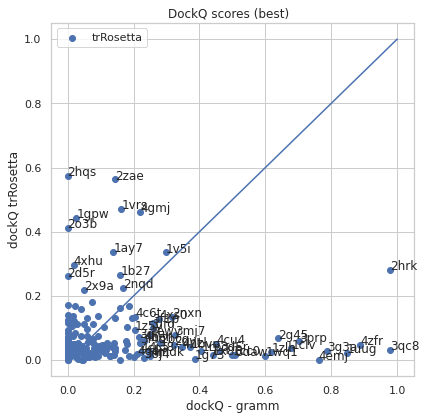

In [41]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ - gramm")
ax.set_ylabel("dockQ "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [42]:
d="TMdock"
foo=pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
data_first[d].dockQ
foo[["dockQ_x","dockQ_y"]]
#cc=np.corrcoef(foo.dockQ_x,foo.dockQ_y)

foo.dockQ_y.isna().unique()
data_first[d].dockQ.isna().unique()

array([], dtype=bool)

TMdock
0 0


Text(20.200000000000003, 0.5, 'dockQ TMdock')

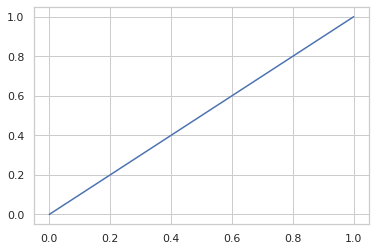

In [43]:
cutoff=0.1
#f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock"]:
    #if d!="N1-merged":continue   
    print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    #sns.jointplot(x="dockQ_x", y="dockQ_y", data=df_merged)
    print(df_merged.dockQ_x.shape[0],df_merged.dockQ_y.shape[0])
    #cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_x)
    #print (cc)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (first model) ") #, CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(20.200000000000003, 0.5, 'dockQ TMdock-nohomology')

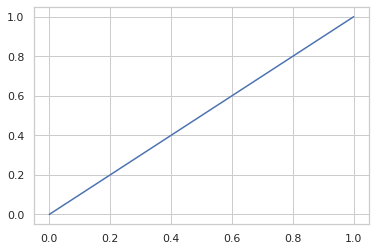

In [44]:
cutoff=0.1
#f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-nohomology"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    #sns.jointplot(x="dockQ_x", y="dockQ_y", data=df_merged)
    #cc=np.corrcoef(df_merged.dockQ_y,df_merged.dockQ_y)
    #print (cc)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (first model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock-nohomology")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ TMdock')

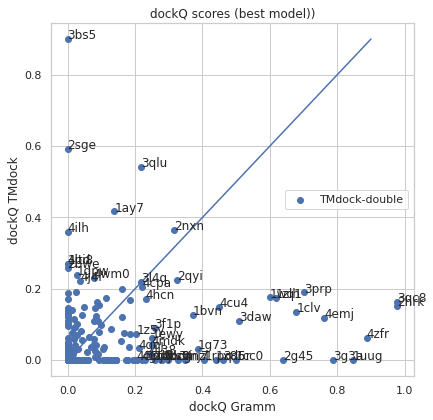

In [45]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (best model))" )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ')

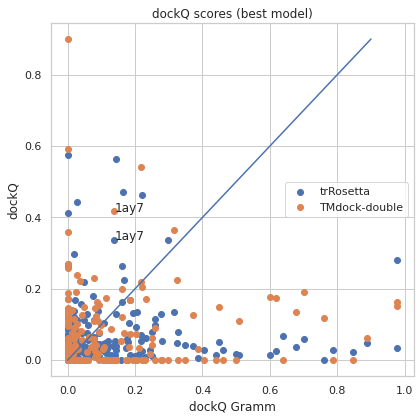

In [46]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta","TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        #if (sstr=="3qc8" or sstr=="2hqs" or sstr=="3bs5" ):
        if (sstr=="1ay7" ):
            #if (df_merged.dockQ_y[i]> cutoff and (df_merged.dockQ_y[i]>df_merged.dockQ_x[i])):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (best model)") 
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [47]:
df_merged = df_max[df_max["params"].isin(["trRosetta","gramm","TMdock-double"])]
df_merged.sort_values("dockQ")

name  lenA  lenB  msa  msaA  msaB  cdhit  \
JHparams      code                                                            
gramm         3cu1  3cu1_u1_A-3cu1_u2_A   132   101  0.0   0.0   0.0  0.038   
              4ged  4ged_u1_A-4ged_u2_A   266   109  0.0   0.0   0.0  0.013   
TMdock-double 3w31  3w31_u1_A-3w31_u2_A   193   150  0.0   0.0   0.0  0.007   
              3wkt  3wkt_u1_A-3wkt_u2_A   604   215  0.0   0.0   0.0  0.010   
gramm         4f7g  4f7g_u1_A-4f7g_u2_A   207   175  0.0   0.0   0.0  0.012   
...                                 ...   ...   ...  ...   ...   ...    ...   
              1uug  1uug_u1_A-1uug_u2_A   230    83  0.0   0.0   0.0  0.656   
              4zfr  4zfr_u1_A-4zfr_u2_A   186    77  0.0   0.0   0.0  0.695   
TMdock-double 3bs5  3bs5_u1_A-3bs5_u2_A    84    76  0.0   0.0   0.0  0.628   
gramm         3qc8  3qc8_u1_A-3qc8_u2_A   169    82  0.0   0.0   0.0  0.857   
              2hrk  2hrk_u1_A-2hrk_u2_A   181   121  0.0   0.0   0.0  0.696   

                    dockQ     fnat     iRMS  ...  CODE         params   tmAB  \
JHparams      code                           ...                               
gramm         3cu1  0.000   13.706   30.130  ...  3cu1          gramm    0.5   
              4ged  0.000   20.229   48.663  ...  4ged          gramm    0.5   
TMdock-double 3w31  0.000   54.147  122.048  ...  3w31  TMdock-double   20.0   
              3wkt  0.000  112.153  231.891  ...  3wkt  TMdock-double    8.5   
gramm         4f7g  0.000   20.195   61.922  ...  4f7g          gramm    0.5   
...                   ...      ...      ...  ...   ...            ...    ...   
              1uug  0.847    3.542    6.927  ...  1uug          gramm    5.0   
              4zfr  0.887    9.940   19.304  ...  4zfr          gramm    0.5   
TMdock-double 3bs5  0.900   16.293   61.530  ...  3bs5  TMdock-double  206.5   
gramm         3qc8  0.977   11.047   18.799  ...  3qc8          gramm    0.5   
              2hrk  0.978   13.721   37.969  ...  2hrk          gramm   61.5   

                    msaAB  tmAB_max  msaAB_max  tmAB_min  msaAB_min  \
JHparams      code                                                    
gramm         3cu1    0.0       1.0        0.0       0.0        0.0   
              4ged    0.0       1.0        0.0       0.0        0.0   
TMdock-double 3w31    0.0      39.0        0.0       1.0        0.0   
              3wkt    0.0      16.0        0.0       1.0        0.0   
gramm         4f7g    0.0       1.0        0.0       0.0        0.0   
...                   ...       ...        ...       ...        ...   
              1uug    0.0       9.0        0.0       1.0        0.0   
              4zfr    0.0       1.0        0.0       0.0        0.0   
TMdock-double 3bs5    0.0     412.0        0.0       1.0        0.0   
gramm         3qc8    0.0       1.0        0.0       0.0        0.0   
              2hrk    0.0     122.0        0.0       1.0        0.0   

                    numcorrect  len  
JHparams      code                   
gramm         3cu1       0.000  233  
              4ged       0.000  375  
TMdock-double 3w31       0.000  343  
              3wkt       0.000  819  
gramm         4f7g       0.000  382  
...                        ...  ...  
              1uug       0.000  313  
              4zfr       0.000  263  
TMdock-double 3bs5       0.986  160  
gramm         3qc8       0.000  251  
              2hrk       0.000  302  

[652 rows x 51 columns]

In [48]:
len(df_merged.loc[df_merged.dockQ>0.2]["CODE"].unique())

59

In [49]:
len(df_merged.loc[(df_merged.params=="trRosetta")&(df_merged.dockQ>0.2 )]["CODE"].unique())

14

In [50]:
len(df_merged.loc[(df_merged.params=="gramm")&(df_merged.dockQ>0.2 )]["CODE"].unique())

40

In [51]:
len(df_merged.loc[(df_merged.params=="TMdock-double")&(df_merged.dockQ>0.2 )]["CODE"].unique())

15

In [52]:
len(df_merged["CODE"].unique())

218

In [53]:
df.loc[df.params=="TMdock-double"].sort_values("dockQ")

name       JHparams lenA lenB msa msaA msaB  cdhit  \
14707  5eg3_u1_A-5eg3_u2_A  TMdock-double  303  105   0    0    0  0.014   
13873  3ona_u1_A-3ona_u2_A  TMdock-double  161   78   0    0    0  0.016   
13872  3ona_u1_A-3ona_u2_A  TMdock-double  161   78   0    0    0  0.026   
13871  3ona_u1_A-3ona_u2_A  TMdock-double  161   78   0    0    0  0.016   
13870  3ona_u1_A-3ona_u2_A  TMdock-double  161   78   0    0    0  0.026   
...                    ...            ...  ...  ...  ..  ...  ...    ...   
13957  3qlu_u1_A-3qlu_u2_A  TMdock-double  384  374   0    0    0  0.398   
13433  2sge_u1_A-2sge_u2_A  TMdock-double  186   57   0    0    0  0.364   
13588  3bs5_u1_A-3bs5_u2_A  TMdock-double   84   76   0    0    0   0.56   
13597  3bs5_u1_A-3bs5_u2_A  TMdock-double   84   76   0    0    0  0.628   
13592  3bs5_u1_A-3bs5_u2_A  TMdock-double   84   76   0    0    0  0.539   

       dockQ    fnat  ...  CODE         params    tmAB msaAB tmAB_max  \
14707      0  19.742  ...  5eg3  TMdock-double     0.5   0.0      1.0   
13873      0   18.45  ...  3ona  TMdock-double    13.0   0.0     25.0   
13872      0  13.859  ...  3ona  TMdock-double    13.0   0.0     25.0   
13871      0  18.312  ...  3ona  TMdock-double    13.0   0.0     25.0   
13870      0  13.966  ...  3ona  TMdock-double    13.0   0.0     25.0   
...      ...     ...  ...   ...            ...     ...   ...      ...   
13957  0.542   3.667  ...  3qlu  TMdock-double  3961.5   0.0   7922.0   
13433  0.593   3.624  ...  2sge  TMdock-double     1.0   0.0      1.0   
13588    0.7   2.688  ...  3bs5  TMdock-double   206.5   0.0    412.0   
13597  0.833   2.384  ...  3bs5  TMdock-double   206.5   0.0    412.0   
13592    0.9   2.876  ...  3bs5  TMdock-double   206.5   0.0    412.0   

      msaAB_max tmAB_min msaAB_min numcorrect  len  
14707       0.0      0.0       0.0          0  408  
13873       0.0      1.0       0.0          0  239  
13872       0.0      1.0       0.0          0  239  
13871       0.0      1.0       0.0          0  239  
13870       0.0      1.0       0.0          0  239  
...         ...      ...       ...        ...  ...  
13957       0.0      1.0       0.0     31.752  758  
13433       0.0      1.0       0.0          0  243  
13588       0.0      1.0       0.0      0.986  160  
13597       0.0      1.0       0.0      0.986  160  
13592       0.0      1.0       0.0      0.986  160  

[2160 rows x 53 columns]

In [54]:
df_merged.groupby(["CODE"]).median().sort_values("dockQ")


lenA   lenB     msa     msaA     msaB     cdhit   dockQ     fnat  \
CODE                                                                      
5eg3  303.0  105.0     0.0      0.0      0.0    0.0340  0.0000  22.4970   
1te1  275.0  191.0     0.0      0.0      0.0    0.0110  0.0000  19.6430   
4pj2  123.0  121.0     0.0      0.0      0.0    0.0270  0.0000  20.2440   
4p4q  292.0  109.0     0.0      0.0      0.0    0.0540  0.0000  20.5830   
1y8x  169.0   98.0     0.0      0.0      0.0    0.0410  0.0000  24.2240   
...     ...    ...     ...      ...      ...       ...     ...      ...   
2hrk  181.0  121.0     0.0      0.0      0.0    0.6960  0.2820  13.7210   
1v5i  276.0   78.0     0.0      0.0      0.0    0.2810  0.2980  16.4660   
2nxn  255.0  148.0     0.0      0.0      0.0    0.1360  0.3170  14.4160   
1vrs  124.0  120.5  1045.5  50159.5  50159.5  989.0375  0.3175   9.2385   
1ay7   97.0   90.0     0.0      0.0      0.0    0.4340  0.3370  12.2940   

          iRMS      LRMS  ...       seqid  rank       tmAB    msaAB  \
CODE                      ...                                         
5eg3   93.4620    1.0000  ...      40.000   0.0   0.500000      0.0   
1te1  218.1660    1.0000  ...     100.000   0.0   0.500000      0.0   
4pj2   99.9320    1.0000  ...      10.000   0.0   0.500000      0.0   
4p4q  244.6850    1.0000  ...      66.667   0.0   0.500000      0.0   
1y8x  106.8720    1.0000  ...      55.556   0.0   0.500000      0.0   
...        ...       ...  ...         ...   ...        ...      ...   
2hrk   75.1980    1.0000  ...      19.718   0.0  61.500000      0.0   
1v5i   69.6880    1.0000  ...      10.000   0.0   1.500000      0.0   
2nxn  200.1340    1.0000  ...      10.000   0.0  17.000000      0.0   
1vrs  130.8735  229.6605  ...  168172.231   1.0   0.567912  25780.5   
1ay7   72.0320    1.0000  ...      10.000   0.0  31.000000      0.0   

        tmAB_max  msaAB_max  tmAB_min  msaAB_min  numcorrect    len  
CODE                                                                 
5eg3    1.000000        0.0   0.00000        0.0       0.000  408.0  
1te1    1.000000        0.0   0.00000        0.0       0.000  466.0  
4pj2    0.698180        0.0   0.00000        0.0       0.000  244.0  
4p4q    1.000000        0.0   0.00000        0.0       0.000  401.0  
1y8x    1.000000        0.0   0.00000        0.0       0.000  267.0  
...          ...        ...       ...        ...         ...    ...  
2hrk  122.000000        0.0   1.00000        0.0       0.000  302.0  
1v5i    2.000000        0.0   1.00000        0.0       0.000  354.0  
2nxn   33.000000        0.0   1.00000        0.0       0.000  403.0  
1vrs    0.642455    50159.5   0.49337     1401.5      26.994  241.0  
1ay7   61.000000        0.0   1.00000        0.0       2.001  187.0  

[218 rows x 48 columns]

Text(0, 0.5, 'dockQ TMdock')

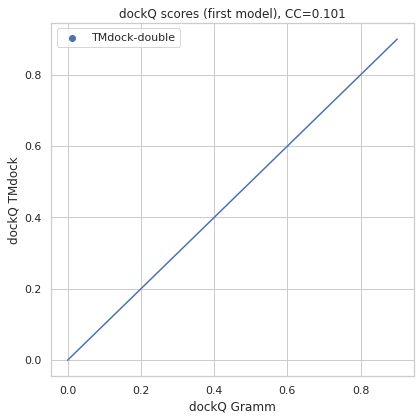

In [55]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    #cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (first model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ TMdock TMdock-double')

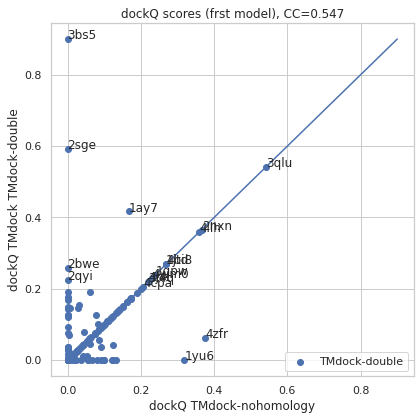

In [56]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["TMdock-nohomology"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ TMdock-nohomology")
ax.set_ylabel("dockQ TMdock "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ TMdock trRosetta')

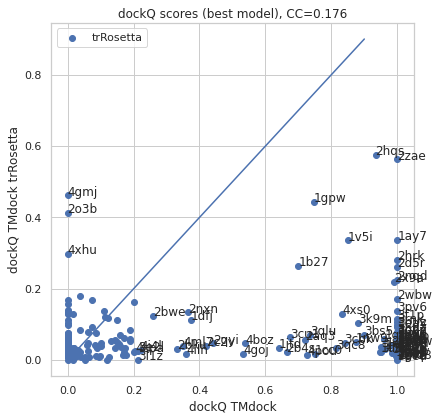

In [57]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["TMdock"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (best model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ TMdock")
ax.set_ylabel("dockQ TMdock "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Text(0, 0.5, 'dockQ  PDB')

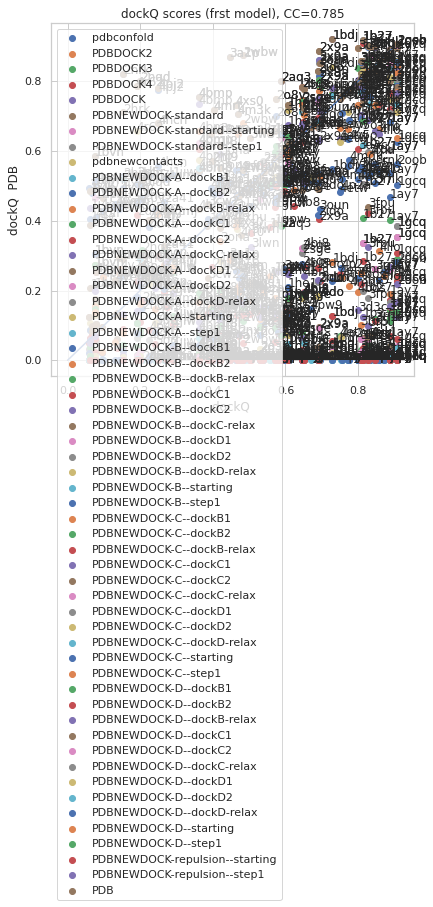

In [58]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDB|^pdb")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-repulsion--step1')

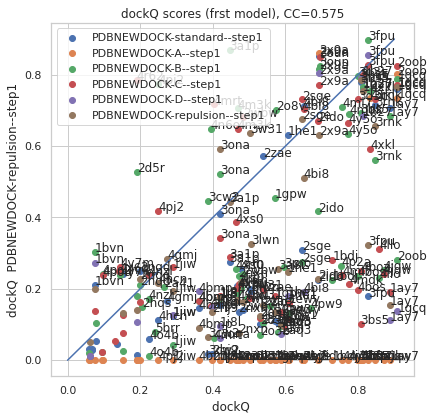

In [59]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*step1.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDB')

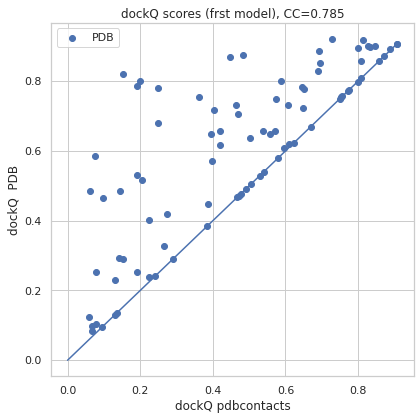

In [60]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("pdbconfold")
pdbset=list(filter(r.match, datasets))
pdbset=["PDB"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        #if (df_merged.dockQ_y[i]- df_merged.dockQ_x[i]>cutoff):
        #    ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ pdbcontacts")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  pdbconfold')

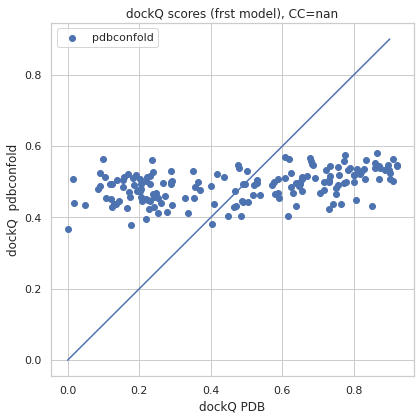

In [61]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("pdbconfold")
pdbset=list(filter(r.match, datasets))
pdbset=["pdbconfold"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["PDB"],data_max[d], on=['code'],how="outer")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        #if (df_merged.dockQ_y[i]- df_merged.dockQ_x[i]>cutoff):
        #    ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ PDB")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

No handles with labels found to put in legend.


Text(0, 0.5, 'dockQ  pdbconfold')

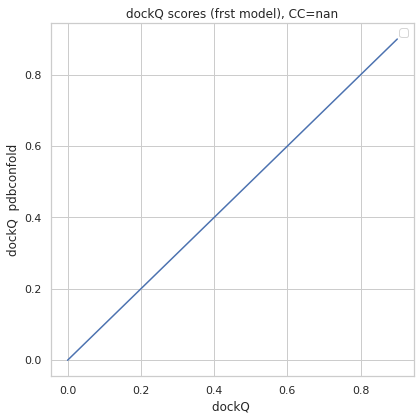

In [62]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-[ABCD]$")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-D--dockB-relax')

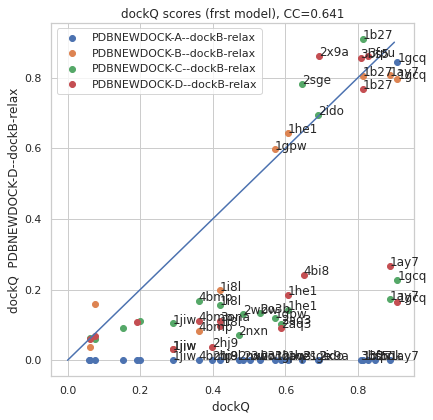

In [63]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*dockB-relax.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-D--dockC-relax')

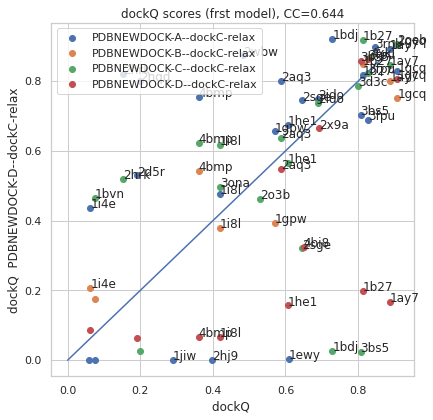

In [64]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*dockC-relax.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ  PDBNEWDOCK-D--dockD-relax')

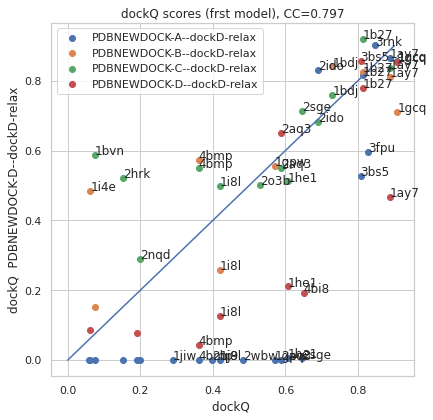

In [65]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*dockD-relax.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'PDBNEWDOCK-C'

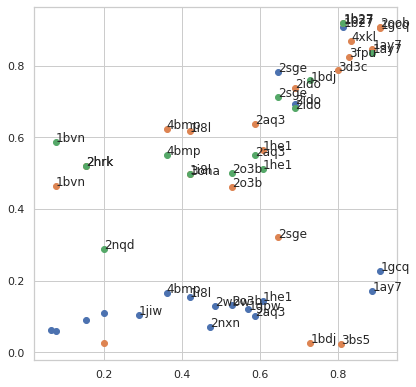

KeyError: 'PDBNEWDOCK-C'

In [66]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-C.*-relax.*")
pdbset=list(filter(r.match, datasets))+["PDBNEWDOCK-C"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'PDBNEWDOCK-B'

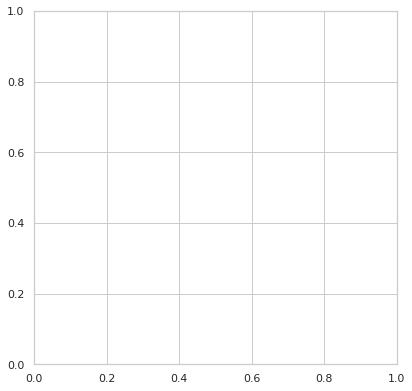

KeyError: 'PDBNEWDOCK-B'

In [67]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-C.*-relax.*")
pdbset=list(filter(r.match, datasets))+["PDBNEWDOCK-C"]
pdbset=["PDBNEWDOCK-B","PDBNEWDOCK-C","PDBNEWDOCK-A--dockC-relax",
        "PDBNEWDOCK-C--dockC-relax","PDBNEWDOCK-B--dockD-relax",
        "PDBNEWDOCK-C--dockD-relax"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'PDBNEWDOCK-repulsion'

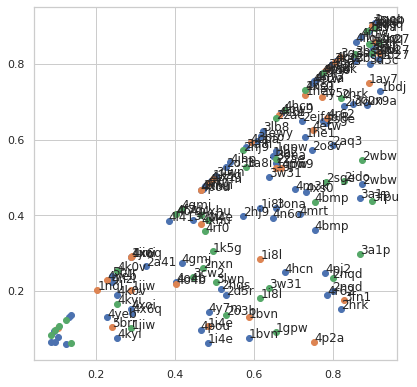

KeyError: 'PDBNEWDOCK-repulsion'

In [68]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-C.*-relax.*")
pdbset=list(filter(r.match, datasets))+["PDBNEWDOCK-C"]
pdbset=["pdbcontacts","pdbnewcontacts","PDBNEWDOCK-standard","PDBNEWDOCK-repulsion","pdbconfold"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    #if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["PDB"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [69]:
r=re.compile(".*relax.*")
#pdbset=list(filter(r.match, datasets))+['PDBNEWDOCK-A','PDBNEWDOCK-B', 'PDBNEWDOCK-C', 'PDBNEWDOCK-D',"pdbcontacts"]
pdbset=sorted(["PDB","PDBNEWDOCK-B","PDBNEWDOCK-C","PDBNEWDOCK-A--dockC-relax",
        "PDBNEWDOCK-C--dockC-relax","PDBNEWDOCK-B--dockD-relax",
        "PDBNEWDOCK-C--dockD-relax","pdbcontacts","pdbnewcontacts","PDBNEWDOCK-standard",
               "PDBNEWDOCK-repulsion","pdbconfold"])


smallset=["1ay7", "1b27", "1bvn", "1gcq", "1gpw", "1he1", "1i4e", "1i8l",
"1jiw", "1k5g", "1nql", "1vg0", "2aq3", "2b4s", "2d5r", "2grx",
"2hj9", "2hrk", "2ido", "2nqd", "2nxn", "2o3b", "2sge", "2wbw",
"2x9a", "2xwb", "2zae", "3a1p", "3a8i", "3bs5", "3buz", "3cw2",
"3cw2", "3fpu", "3lwn", "3ona", "3rnk", "3vlb", "3w31", "3wkt",
"4bi8", "4bmp", "4gmj", "4hcn", "4k0v", "4kyi", "4o4b", "4rf0",
"4xhu", "4yoc"]
codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
codes=smallset
codes=df_max.loc[(df_max.params=="PDBNEWDOCK-A--dockC-relax")&(df_max.params.isin(pdbset) )]["CODE"].unique()
codes=df_max.loc[(df_max.params=="PDBNEWDOCK-C")&(df_max.params.isin(pdbset) )]["CODE"].unique()

codes=smallset

In [70]:
cutoff=0.2
newdf=df_max.loc[df_max.dockQ>cutoff]
newdf=newdf.reset_index()

PDB
PDBNEWDOCK-A--dockC-relax
PDBNEWDOCK-B
PDBNEWDOCK-B--dockD-relax
PDBNEWDOCK-C
PDBNEWDOCK-C--dockC-relax
PDBNEWDOCK-C--dockD-relax
PDBNEWDOCK-repulsion
PDBNEWDOCK-standard
pdbconfold
pdbcontacts
pdbnewcontacts


IndexError: index out of bounds

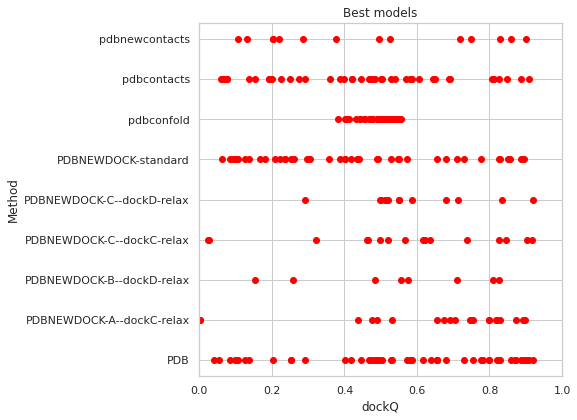

IndexError: index out of bounds

In [71]:
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(pdbset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))


In [72]:
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-multimerged', '-N 1 -E 1.e-10 --cpu 8 ',
       'N1-top1000-merged', 'N1-top1000', 'N1-top100', 'N1-top2000',
       'N1-top500', 'N3dock', '-N 3 --incE 1.e-2', 'N3-merged',
       'N3-multimerged', 'N3-newdockA', 'N3-newdockB', 'N3-newdockC',
       'N5-newdockA', 'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8',
       'pdbconfold', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4',
       'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting',
       'PDBNEWDOCK-A--step1', 'PD

In [73]:
pdbset=[ 'N3dock',
       'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA','N5-newdockB',
       'N5-newdockC', '-N 5 --cpu 8',"-N 3 --cpu 8"]
codes=df_max.loc[(df_max.params=="N3-newdockC")&(df_max.params.isin(pdbset) )]["CODE"].unique()
codes

array(['1ay7', '1b27', '1bvn', '1gcq', '1gpw', '1he1', '1i4e', '1i8l',
       '1jiw', '1k5g', '1nql', '1vg0', '2aq3', '2b4s', '2d5r', '2hj9',
       '2hrk', '2ido', '2nqd', '2nxn', '2o3b', '2sge', '2wbw', '2x9a',
       '2zae', '3a1p', '3a8i', '3bs5', '3cw2', '3fpu', '3lwn', '3ona',
       '3rnk', '3w31', '4bi8', '4bmp', '4gmj', '4hcn', '4xhu'],
      dtype=object)

Text(0, 0.5, 'dockQ  -N 3 --cpu 8')

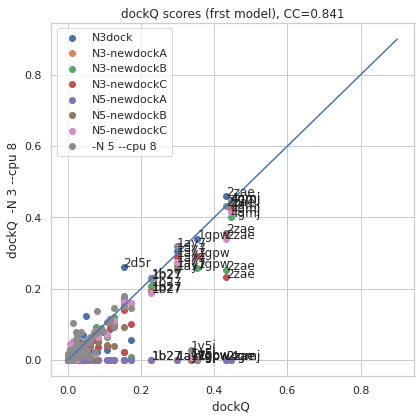

In [74]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="-N 3 --cpu 8":continue
    df_merged = pd.merge(data_max["-N 3 --cpu 8"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

-N 3 --cpu 8 39
-N 5 --cpu 8 39
N3-newdockA 39
N3-newdockB 38
N3-newdockC 39
N3dock 39
N5-newdockA 39
N5-newdockB 39
N5-newdockC 39


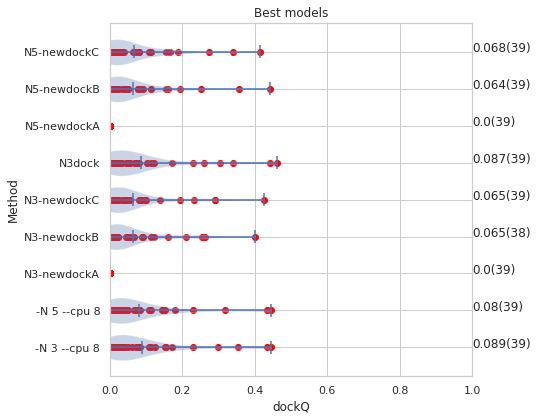

In [75]:
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(pdbset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    print (d,len(data[i]))
    i+=1
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))


In [76]:
pdbset=sorted(["N1","N3"])

In [77]:
for d in pdbset:
    print (d,len(df_max.loc[(df_max.params==d)]["CODE"].unique()))

N1 0
N3 0


In [78]:
all_df

JHparams  code                 name  lenA  lenB     msa     msaA  \
0    -N 3 --cpu 8  1ay7  1ay7_u2_A-1ay7_u1_A    97    97  1060.0   2034.0   
1    -N 3 --cpu 8  1b27  1b27_u2_A-1b27_u1_A   109   109   733.0   2034.0   
2    -N 3 --cpu 8  1bvn  1bvn_u2_A-1bvn_u1_A   496   496    95.0  52623.0   
3    -N 3 --cpu 8  1gcq  1gcq_u2_A-1gcq_u1_A    66    66  1365.0  77704.0   
4    -N 3 --cpu 8  1gpw  1gpw_u2_A-1gpw_u1_A   252   252  7137.0  67629.0   
..            ...   ...                  ...   ...   ...     ...      ...   
345   N5-newdockC  4bi8  4bi8_u1_A-4bi8_u2_A   164    94    51.0    291.0   
346   N5-newdockC  4bmp  4bmp_u1_A-4bmp_u2_A   301   118  4607.0   9429.0   
347   N5-newdockC  4gmj  4gmj_u2_A-4gmj_u1_A   253   253  1189.0   6344.0   
348   N5-newdockC  4hcn  4hcn_u1_A-4hcn_u2_A   250    77     1.0     20.0   
349   N5-newdockC  4xhu  4xhu_u2_A-4xhu_u1_A   352   352   410.0   9970.0   

        msaB   cdhit  dockQ  ...  CODE        params      tmAB    msaAB  \
0     2034.0  1026.0  0.298  ...  1ay7  -N 3 --cpu 8  0.828190   1759.5   
1     2034.0   656.0  0.229  ...  1b27  -N 3 --cpu 8  0.824750   1759.0   
2    52623.0    85.0  0.013  ...  1bvn  -N 3 --cpu 8  0.619740  26373.0   
3    77704.0   771.0  0.115  ...  1gcq  -N 3 --cpu 8  0.555390  77600.5   
4    67629.0  5348.0  0.354  ...  1gpw  -N 3 --cpu 8  0.889770  63047.5   
..       ...     ...    ...  ...   ...           ...       ...      ...   
345    382.0    50.0  0.026  ...  4bi8   N5-newdockC  0.695005    336.5   
346  15729.0  2901.0  0.004  ...  4bmp   N5-newdockC  0.811060  12579.0   
347   6344.0   546.0  0.414  ...  4gmj   N5-newdockC  0.831935   3998.5   
348  41925.0     1.0  0.014  ...  4hcn   N5-newdockC  0.467315  20972.5   
349   9970.0   240.0  0.007  ...  4xhu   N5-newdockC  0.730560   5259.0   

     tmAB_max  msaAB_max  tmAB_min  msaAB_min  numcorrect  len  
0     0.84625     2034.0   0.81013     1485.0      53.985  187  
1     0.85428     2034.0   0.79522     1484.0      49.025  199  
2     0.70905    52623.0   0.53043      123.0       0.000  571  
3     0.63426    77704.0   0.52080    77497.0      71.760  123  
4     0.89718    67629.0   0.88236    58466.0     130.000  456  
..        ...        ...       ...        ...         ...  ...  
345   0.78100      382.0   0.60901      291.0       0.000  258  
346   0.86858    15729.0   0.75354     9429.0       0.000  419  
347   0.85148     6344.0   0.82721     1653.0     139.104  489  
348   0.61756    41925.0   0.31707       20.0       0.000  327  
349   0.75557     9970.0   0.70555      548.0       0.000  447  

[350 rows x 53 columns]

In [79]:
cutoff=0.2
newdf=df_max.loc[df_max.dockQ>cutoff]
newdf=newdf.reset_index()


In [80]:
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-multimerged', '-N 1 -E 1.e-10 --cpu 8 ',
       'N1-top1000-merged', 'N1-top1000', 'N1-top100', 'N1-top2000',
       'N1-top500', 'N3dock', '-N 3 --incE 1.e-2', 'N3-merged',
       'N3-multimerged', 'N3-newdockA', 'N3-newdockB', 'N3-newdockC',
       'N5-newdockA', 'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8',
       'pdbconfold', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4',
       'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting',
       'PDBNEWDOCK-A--step1', 'PD

In [81]:
r=re.compile(".*relax.*")
pdbset=list(filter(r.match, datasets))+['PDBNEWDOCK-A','PDBNEWDOCK-B', 'PDBNEWDOCK-C', 'PDBNEWDOCK-D',"pdbcontacts","pdbconfold","PDB"]


smallset=["1ay7", "1b27", "1bvn", "1gcq", "1gpw", "1he1", "1i4e", "1i8l",
"1jiw", "1k5g", "1nql", "1vg0", "2aq3", "2b4s", "2d5r", "2grx",
"2hj9", "2hrk", "2ido", "2nqd", "2nxn", "2o3b", "2sge", "2wbw",
"2x9a", "2xwb", "2zae", "3a1p", "3a8i", "3bs5", "3buz", "3cw2",
"3cw2", "3fpu", "3lwn", "3ona", "3rnk", "3vlb", "3w31", "3wkt",
"4bi8", "4bmp", "4gmj", "4hcn", "4k0v", "4kyi", "4o4b", "4rf0",
"4xhu", "4yoc"]
codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
codes=smallset
codes=df_max.loc[(df_max.params=="PDBNEWDOCK-A")&(df_max.params.isin(pdbset) )]["CODE"].unique()


ValueError: zero-size array to reduction operation minimum which has no identity

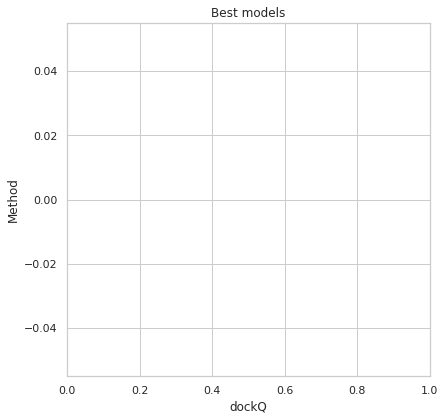

ValueError: zero-size array to reduction operation minimum which has no identity

In [82]:
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(pdbset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    #print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))


In [83]:
codes

array([], dtype=object)

In [84]:
all_df

Empty DataFrame
Columns: [JHparams, code, name, lenA, lenB, msa, msaA, msaB, cdhit, dockQ, fnat, iRMS, LRMS, fnonnat, mm, tmA, tmB, long, med, longPPV, medPPV, longA, medA, longPPVA, medPPVA, longB, medB, longPPVB, medPPVB, short, shortPPV, shortA, shortPPVA, shortB, shortPPVB, shortpdb, medpdb, longpdb, avprob, auc, evalue, seqid, rank, CODE, params, tmAB, msaAB, tmAB_max, msaAB_max, tmAB_min, msaAB_min, numcorrect, len]
Index: []

[0 rows x 53 columns]

IndexError: index out of bounds

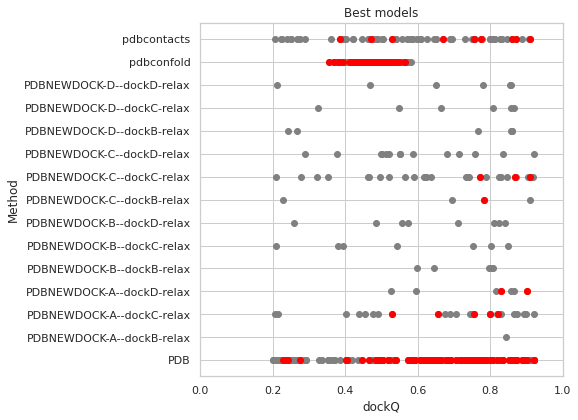

IndexError: index out of bounds

In [85]:
# FInd best method for each model.
codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
plt.scatter(best_df.dockQ,best_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    #print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[best_df.JHparams[i]]==0:
        done[best_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[best_df.JHparams[i]],3))+"("+str(length[good_df.JHparams[i]])+")"
                    ,(1.0, best_df.JHparams[i]))
for d in datasets:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[good_df.JHparams[i]]==0:
        done[good_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.1, good_df.JHparams[i]))
        #ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        #ax.annotate("("+str(length[good_df.JHparams[i]])+")",(1.2, good_df.JHparams[i]))


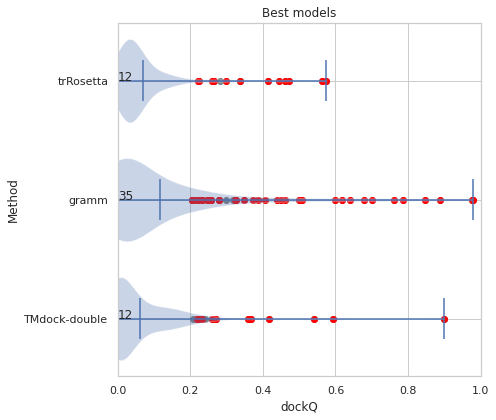

In [86]:
compareset=["trRosetta","gramm","TMdock-double"]
codes=df_max.loc[df_max.params.isin(compareset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(compareset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(compareset))].reset_index()
plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
plt.scatter(best_df.dockQ,best_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(compareset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    #print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[best_df.JHparams[i]]==0:
        done[best_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        #ax.annotate(str(round(average[best_df.JHparams[i]],3))+
        #            "("+str(length[good_df.JHparams[i]])+")"
        #            ,(1.0, best_df.JHparams[i]))
for d in datasets:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[good_df.JHparams[i]]==0:
        done[good_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.1, good_df.JHparams[i]))
        #ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        #ax.annotate("("+str(length[good_df.JHparams[i]])+")",(1.2, good_df.JHparams[i]))


In [87]:
best_df

index       JHparams  code                 name  lenA  lenB     msa  \
0     915          gramm  2hrk  2hrk_u1_A-2hrk_u2_A   181   121     0.0   
1     926          gramm  3qc8  3qc8_u1_A-3qc8_u2_A   169    82     0.0   
2     861  TMdock-double  3bs5  3bs5_u1_A-3bs5_u2_A    84    76     0.0   
3     939          gramm  4zfr  4zfr_u1_A-4zfr_u2_A   186    77     0.0   
4     907          gramm  1uug  1uug_u1_A-1uug_u2_A   230    83     0.0   
5     921          gramm  3g3a  3g3a_u1_A-3g3a_u2_A   166   130     0.0   
6     931          gramm  4emj  4emj_u1_A-4emj_u2_A   403   106     0.0   
7     925          gramm  3prp  3prp_u1_A-3prp_u2_A   184    77     0.0   
8     902          gramm  1clv  1clv_u1_A-1clv_u2_A   471    33     0.0   
9     914          gramm  2g45  2g45_u1_A-2g45_u2_A   114    77     0.0   
10    912          gramm  1zlh  1zlh_u1_A-1zlh_u2_A   306    76     0.0   
11    909          gramm  1wq1  1wq1_u1_A-1wq1_u2_A   325   167     0.0   
12    860  TMdock-double  2sge  2sge_u1_A-2sge_u2_A   186    57     0.0   
13   1248      trRosetta  2hqs  2hqs_u2_A-2hqs_u1_A   398   398  2536.0   
14   1253      trRosetta  2zae  2zae_u2_A-2zae_u1_A   107   107  1125.0   
15    863  TMdock-double  3qlu  3qlu_u1_A-3qlu_u2_A   384   374     0.0   
16    919          gramm  3daw  3daw_u1_A-3daw_u2_A   360   143     0.0   
17    901          gramm  1cc0  1cc0_u1_A-1cc0_u2_A   178   149     0.0   
18   1246      trRosetta  1vrs  1vrs_u2_A-1vrs_u1_A   124   124  2091.0   
19    918          gramm  3d5r  3d5r_u1_A-3d5r_u2_A   295    62     0.0   
20   1254      trRosetta  4gmj  4gmj_u2_A-4gmj_u1_A   253   253  1189.0   
21    930          gramm  4cu4  4cu4_u1_A-4cu4_u2_A   706    22     0.0   
22   1244      trRosetta  1gpw  1gpw_u2_A-1gpw_u1_A   252   252  7203.0   
23    910          gramm  1x86  1x86_u1_A-1x86_u2_A   353   181     0.0   
24    854  TMdock-double  1ay7  1ay7_u1_A-1ay7_u2_A    97    90     0.0   
25   1251      trRosetta  2o3b  2o3b_u2_A-2o3b_u1_A   240   240   456.0   
26    906          gramm  1rpq  1rpq_u1_A-1rpq_u2_A   174    22     0.0   
27    904          gramm  1g73  1g73_u1_A-1g73_u2_A   174    97     0.0   
28    900          gramm  1bvn  1bvn_u1_A-1bvn_u2_A   496    75     0.0   
29    858  TMdock-double  2nxn  2nxn_u1_A-2nxn_u2_A   255   148     0.0   
30    866  TMdock-double  4ilh  4ilh_u1_A-4ilh_u2_A   301   256     0.0   
31    937          gramm  4nzl  4nzl_u1_A-4nzl_u2_A   219   100     0.0   
32   1245      trRosetta  1v5i  1v5i_u2_A-1v5i_u1_A   276   276  1922.0   
33    923          gramm  3mj7  3mj7_u1_A-3mj7_u2_A   228   187     0.0   
34    917          gramm  2qyi  2qyi_u1_A-2qyi_u2_A   224   180     0.0   
35   1255      trRosetta  4xhu  4xhu_u2_A-4xhu_u1_A   352   352   410.0   
36    913          gramm  2bcg  2bcg_u1_A-2bcg_u2_A   440   179     0.0   
37    938          gramm  4xs0  4xs0_u1_A-4xs0_u2_A   147   141     0.0   
38    864  TMdock-double  4bi8  4bi8_u1_A-4bi8_u2_A   164    94     0.0   
39    856  TMdock-double  1jtd  1jtd_u1_A-1jtd_u2_A   270   264     0.0   
40   1243      trRosetta  1b27  1b27_u2_A-1b27_u1_A   109   109   733.0   
41   1247      trRosetta  2d5r  2d5r_u2_A-2d5r_u1_A   265   265   521.0   
42    857  TMdock-double  2bwe  2bwe_u1_A-2bwe_u2_A    78    47     0.0   
43    905          gramm  1lfd  1lfd_u1_A-1lfd_u2_A   167    88     0.0   
44    920          gramm  3f1p  3f1p_u1_A-3f1p_u2_A   120   115     0.0   
45    903          gramm  1ewy  1ewy_u1_A-1ewy_u2_A   304    99     0.0   
46    936          gramm  4mdk  4mdk_u1_A-4mdk_u2_A   165    77     0.0   
47    935          gramm  4j38  4j38_u1_A-4j38_u2_A   152   124     0.0   
48    934          gramm  4hcn  4hcn_u1_A-4hcn_u2_A   250    77     0.0   
49    924          gramm  3oj4  3oj4_u1_A-3oj4_u2_A   151    77     0.0   
50    868  TMdock-double  4wm0  4wm0_u1_A-4wm0_u2_A   291    40     0.0   
51   1250      trRosetta  2nqd  2nqd_u2_A-2nqd_u1_A   221   221   266.0   
52    929          gramm  4cp

In [88]:
codes

array(['1ay7', '1b27', '1bdj', '1buh', '1bvn', '1cc0', '1clv', '1dfj',
       '1eay', '1eer', '1ewy', '1fle', '1fq1', '1g6v', '1g73', '1gcq',
       '1gg2', '1gpw', '1he1', '1i2m', '1i4e', '1i8l', '1ib1', '1jiw',
       '1jk9', '1jtd', '1k5g', '1kgy', '1lb2', '1lfd', '1mq8', '1nbf',
       '1nql', '1nw9', '1oc0', '1pvh', '1qav', '1r8s', '1rpq', '1s1q',
       '1te1', '1tmq', '1uug', '1v5i', '1vg0', '1wq1', '1wrd', '1x86',
       '1xt9', '1y64', '1y8x', '1ycs', '1yu6', '1yvb', '1z5y', '1zlh',
       '2a41', '2a5d', '2a9k', '2abz', '2aq3', '2b4s', '2bcg', '2bcn',
       '2bku', '2bwe', '2c0l', '2c2v', '2ch4', '2d5r', '2ejf', '2g45',
       '2grx', '2gwf', '2hj9', '2hqs', '2hrk', '2i25', '2ido', '2iwt',
       '2nqd', '2nxn', '2o25', '2o2v', '2o3b', '2o8v', '2oob', '2qyi',
       '2sge', '2uy7', '2v55', '2vdb', '2vrr', '2wbw', '2wy7', '2wy8',
       '2x9a', '2xgy', '2xwb', '2zae', '3a1p', '3a8i', '3av0', '3bh6',
       '3bs5', '3buz', '3bx1', '3cbk', '3cu1', '3cw2', '3d3c', '3d5r',
      

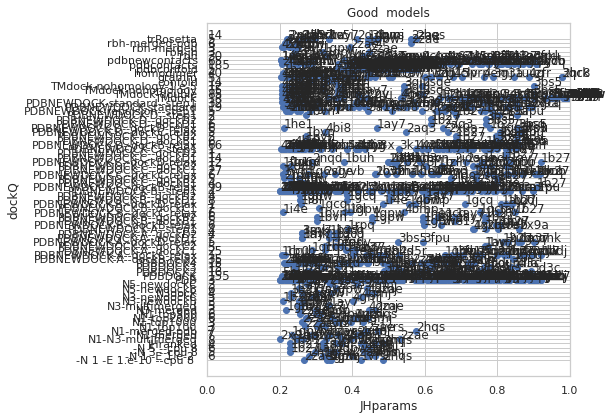

In [89]:

f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(newdf.dockQ,newdf.JHparams)
#cc=np.corrcoef(newdf.dockQ,newdf.len)
ax.set_title("Good  models")
ax.set_xlabel("JHparams")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
for d in datasets:
    done[d]=0
for i, txt in enumerate(newdf.name):
    #print (i,txt)
    sstr=txt[0:4]
    ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(newdf.loc[newdf.JHparams==newdf.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[newdf.JHparams[i]]==0:
        done[newdf.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, newdf.JHparams[i]))

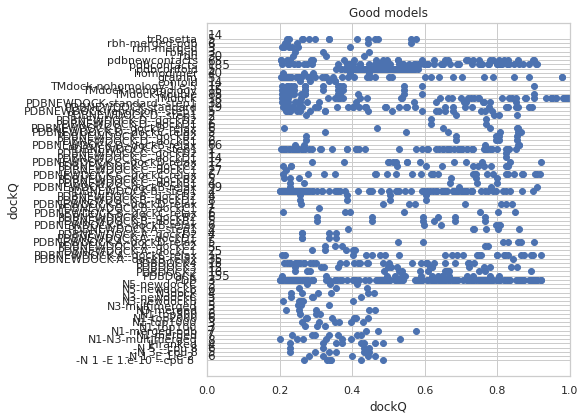

In [90]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(newdf.dockQ,newdf.JHparams)
#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Good models")
ax.set_xlabel("dockQ")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
for d in datasets:
    done[d]=0
for i, txt in enumerate(newdf.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(newdf.loc[newdf.JHparams==newdf.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[newdf.JHparams[i]]==0:
        done[newdf.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, newdf.JHparams[i]))

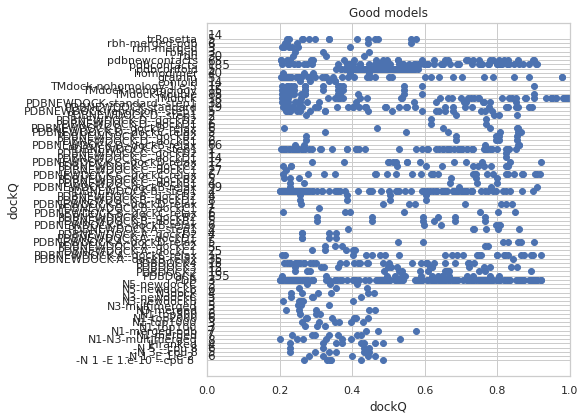

In [91]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(newdf.dockQ,newdf.JHparams)
#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Good models")
ax.set_xlabel("dockQ")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
for d in datasets:
    done[d]=0
for i, txt in enumerate(newdf.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(newdf.loc[newdf.JHparams==newdf.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[newdf.JHparams[i]]==0:
        done[newdf.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, newdf.JHparams[i]))

In [92]:
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-multimerged', '-N 1 -E 1.e-10 --cpu 8 ',
       'N1-top1000-merged', 'N1-top1000', 'N1-top100', 'N1-top2000',
       'N1-top500', 'N3dock', '-N 3 --incE 1.e-2', 'N3-merged',
       'N3-multimerged', 'N3-newdockA', 'N3-newdockB', 'N3-newdockC',
       'N5-newdockA', 'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8',
       'pdbconfold', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4',
       'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting',
       'PDBNEWDOCK-A--step1', 'PD

In [93]:
# here we find what method is best for each target

r = re.compile("^PDB.*|^TMd.*|^gramm|trRosetta|^pdb.*")
excludecolumns = list(filter(r.match, datasets)) # Read Note
print(excludecolumns)
excludecolumns+=["confold","rbh-merged-pdb"]
tempdf=newdf.loc[~newdf.JHparams.isin(excludecolumns)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

['gramm', 'pdbconfold', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B--dockB1', 'PDBNEWDOCK-B--dockB2', 'PDBNEWDOCK-B--dockB-relax', 'PDBNEWDOCK-B--dockC1', 'PDBNEWDOCK-B--dockC2', 'PDBNEWDOCK-B--dockC-relax', 'PDBNEWDOCK-B--dockD1', 'PDBNEWDOCK-B--dockD2', 'PDBNEWDOCK-B--dockD-relax', 'PDBNEWDOCK-B--starting', 'PDBNEWDOCK-B--step1', 'PDBNEWDOCK-C--dockB1', 'PDBNEWDOCK-C--dockB2', 'PDBNEWDOCK-C--dockB-relax', 'PDBNEWDOCK-C--dockC1', 'PDBNEWDOCK-C--dockC2', 'PDBNEWDOCK-C--dockC-relax', 'PDBNEWDOCK-C--dockD1', 'PDBNEWDOCK-C--dockD2', 'PDBNEWDOCK-C--dockD-relax', 'PDBNEWDOCK-C--star

index           JHparams  code                 name  lenA  lenB     msa  \
9       8     -N 1 -E 1.e-2   2hrk  2hrk_u1_A-2hrk_u2_A   181   121    59.0   
7      14       -N 3 --cpu 8  1v5i  1v5i_u2_A-1v5i_u1_A   276   276  1922.0   
3      28           JHranked  4gmj  4gmj_u2_A-4gmj_u1_A   253   253   894.0   
5      23           JHranked  1gpw  1gpw_u2_A-1gpw_u1_A   252   252  7137.0   
1      34  N1-N3-multimerged  2zae  2zae_u1_A-2zae_u2_A   107    93   100.0   
10     30  N1-N3-multimerged  1b27  1b27_u2_A-1b27_u1_A   109   109   100.0   
13     33  N1-N3-multimerged  2x9a  2x9a_u1_A-2x9a_u2_A   103    63     3.0   
4      39          N1-merged  2o3b  2o3b_u2_A-2o3b_u1_A   240   240   456.0   
8      42          N1-merged  4xhu  4xhu_u2_A-4xhu_u1_A   352   352   410.0   
0      44      N1-merged-pdb  2hqs  2hqs_u2_A-2hqs_u1_A   398   398  2368.0   
2      43      N1-merged-pdb  1vrs  1vrs_u2_A-1vrs_u1_A   124   124   836.0   
6      69     N3-multimerged  1ay7  1ay7_u2_A-1ay7_u1_A    97    97  1060.0   
11     84             N3dock  2d5r  2d5r_u2_A-2d5r_u1_A   265   265   521.0   
12   1232         rbh-merged  2nqd  2nqd_u1_A-2nqd_u2_A   221   111    18.0   

       msaA     msaB   cdhit  ...  CODE             params      tmAB    msaAB  \
9     397.0     64.0    56.0  ...  2hrk     -N 1 -E 1.e-2   0.677510    230.5   
7   54177.0  54177.0  1646.0  ...  1v5i       -N 3 --cpu 8  0.826270  33121.5   
3    3700.0   3590.0   429.0  ...  4gmj           JHranked  0.822735   2643.0   
5   67629.0  58466.0  5343.0  ...  1gpw           JHranked  0.889770  63047.5   
1    1659.0   1521.0    72.0  ...  2zae  N1-N3-multimerged  0.797890   1590.0   
10   2034.0   2034.0    99.0  ...  1b27  N1-N3-multimerged  0.807610   1759.0   
13   2604.0     18.0     3.0  ...  2x9a  N1-N3-multimerged  0.522710   1311.0   
4    5431.0   5431.0   301.0  ...  2o3b          N1-merged  0.727490   2974.5   
8    8381.0   8381.0   234.0  ...  4xhu          N1-merged  0.829155   4344.0   
0    9156.0   9156.0  1989.0  ...  2hqs      N1-merged-pdb  0.969605   6972.0   
2    1396.0   1396.0   806.0  ...  1vrs      N1-merged-pdb  0.989810   1320.5   
6    2034.0   2034.0   989.0  ...  1ay7     N3-multimerged  0.821500   1759.5   
11   6154.0   6154.0   226.0  ...  2d5r             N3dock  0.774685   3962.5   
12  21051.0    801.0    18.0  ...  2nqd         rbh-merged  0.832645  10926.0   

    tmAB_max  msaAB_max  tmAB_min  msaAB_min  numcorrect  len  
9    0.70198      397.0   0.65304       64.0       1.972  302  
7    0.89294    54177.0   0.75960    12066.0       1.000  354  
3    0.85202     3700.0   0.79423     1586.0     135.907  489  
5    0.89718    67629.0   0.88236    58466.0     179.000  456  
1    0.83098     1659.0   0.76480     1521.0       7.000  200  
10   0.84948     2034.0   0.76574     1484.0      27.000  199  
13   0.66453     2604.0   0.38089       18.0       2.001  166  
4    0.83406     5431.0   0.62495      518.0      29.008  384  
8    0.84232     8381.0   0.81599      307.0      19.910  447  
0    0.97016     9156.0   0.96905     4788.0     100.035  507  
2    0.99288     1396.0   0.98674     1245.0      53.988  241  
6    0.83639     2034.0   0.81110     1485.0      53.985  187  
11   0.87927     6154.0   0.68937     1771.0      17.996  386  
12   0.85500    21051.0   0.81029      801.0       0.000  332  

[14 rows x 54 columns]

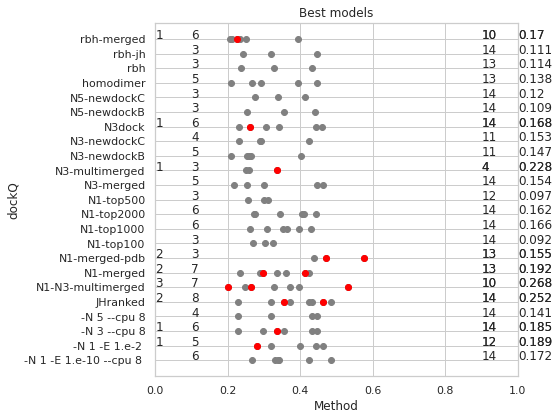

In [94]:
# FInd best method for each model.
codes=best_df["code"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
good_df=newdf.loc[(newdf.code.isin(codes))&(~newdf.JHparams.isin(excludecolumns))].reset_index()
plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
plt.scatter(best_df.dockQ,best_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_xlabel("Method")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
for d in datasets:
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[best_df.JHparams[i]]==0:
        done[best_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[best_df.JHparams[i]],3)),(1.0, best_df.JHparams[i]))
        ax.annotate(str(length[best_df.JHparams[i]]),(.9, best_df.JHparams[i]))
for d in datasets:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[good_df.JHparams[i]]==0:
        done[good_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.1, good_df.JHparams[i]))
        ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        ax.annotate(str(length[good_df.JHparams[i]]),(.9, good_df.JHparams[i]))


In [95]:
df.sort_values('dockQ', ascending=False).drop_duplicates(["code"])

name                 JHparams lenA lenB   msa    msaA  \
18320  3rnk_u1_A-3rnk_u2_A                   TMdock  113  105     0       0   
17879  2zae_u1_A-2zae_u2_A                   TMdock  107   93     0       0   
17689  2nqd_u1_A-2nqd_u2_A                   TMdock  221  111     0       0   
17199  1nbf_u1_A-1nbf_u2_A                   TMdock  340   78     0       0   
17719  2o2v_u1_A-2o2v_u2_A                   TMdock  114   94     0       0   
...                    ...                      ...  ...  ...   ...     ...   
24161  3wkt_u1_A-3wkt_u2_A                      PDB  604  215  1353   51548   
23891  5eg3_u1_A-5eg3_u2_A                      PDB  303  105   421  565997   
24029  4yoc_u1_A-4yoc_u2_A                      PDB  905  530   333   31492   
16608  4ol0_u1_A-4ol0_u2_A        TMdock-nohomology  890  206     0       0   
4219   4c0o_u2_A-4c0o_u1_A  -N 1 -E 1.e-10 --cpu 8   114  890   476    2618   

        msaB  cdhit  dockQ    fnat  ...  CODE                   params  \
18320      0      1      1       0  ...  3rnk                   TMdock   
17879      0      1      1       0  ...  2zae                   TMdock   
17689      0      1      1       0  ...  2nqd                   TMdock   
17199      0      1      1       0  ...  1nbf                   TMdock   
17719      0      1      1       0  ...  2o2v                   TMdock   
...      ...    ...    ...     ...  ...   ...                      ...   
24161   3679   1026  0.097     0.2  ...  3wkt                      PDB   
23891  25926    205  0.094       0  ...  5eg3                      PDB   
24029   4076    187  0.054   0.159  ...  4yoc                      PDB   
16608      0  0.037  0.053  20.385  ...  4ol0        TMdock-nohomology   
4219    2762    285  0.021       0  ...  4c0o  -N 1 -E 1.e-10 --cpu 8    

             tmAB     msaAB    tmAB_max msaAB_max tmAB_min msaAB_min  \
18320  591.500000       0.0  1182.00000       0.0  1.00000       0.0   
17879   46.000000       0.0    91.00000       0.0  1.00000       0.0   
17689    3.500000       0.0     6.00000       0.0  1.00000       0.0   
17199    0.500000       0.0     1.00000       0.0  0.00000       0.0   
17719    6.000000       0.0    11.00000       0.0  1.00000       0.0   
...           ...       ...         ...       ...      ...       ...   
24161    0.310460   27613.5     0.31125   51548.0  0.30967    3679.0   
23891    0.909250  295961.5     0.91808  565997.0  0.90042   25926.0   
24029    0.253670   17784.0     0.32173   31492.0  0.18561    4076.0   
16608    1.500000       0.0     2.00000       0.0  1.00000       0.0   
4219     0.497665    2690.0     0.55139    2762.0  0.44394    2618.0   

      numcorrect   len  
18320      5.088   218  
17879          5   200  
17689          0   332  
17199          0   418  
17719          0   208  
...          ...   ...  
24161          0   819  
23891          0   408  
24029          0  1435  
16608          0  1096  
4219           0  1004  

[218 rows x 53 columns]

In [96]:
df.loc[(df.dockQ>cutoff) & (~df.JHparams.isin(excludecolumns))].groupby("name").max()


JHparams  lenA  lenB     msa      msaA  \
name                                                                   
1ay7_u1_A-1ay7_u2_A             rbh-jh    97    90  1060.0    1485.0   
1ay7_u2_A-1ay7_u1_A          homodimer    90    97  1060.0    2034.0   
1b27_u1_A-1b27_u2_A          homodimer   109    90   733.0    1484.0   
1b27_u2_A-1b27_u1_A          homodimer    90   109   733.0    2034.0   
1gpw_u1_A-1gpw_u2_A         rbh-merged   252   204  7137.0   58466.0   
1gpw_u2_A-1gpw_u1_A             rbh-jh   204   252  7137.0   67629.0   
1v5i_u1_A-1v5i_u2_A       -N 3 --cpu 8   276    78  1922.0   54177.0   
1vrs_u1_A-1vrs_u2_A         N1-top2000   124   117   836.0  100319.0   
1vrs_u2_A-1vrs_u1_A         N1-top2000   117   124  2091.0    2803.0   
2d5r_u2_A-2d5r_u1_A             N3dock   121   265   521.0    1771.0   
2hqs_u1_A-2hqs_u2_A         N1-top2000   398   109  2396.0  376708.0   
2hqs_u2_A-2hqs_u1_A         N1-top2000   109   398  2396.0   15892.0   
2hrk_u1_A-2hrk_u2_A     -N 1 -E 1.e-2    181   121    59.0     397.0   
2nqd_u1_A-2nqd_u2_A         rbh-merged   221   111    18.0   21051.0   
2o3b_u1_A-2o3b_u2_A         rbh-merged   240   144   100.0    5431.0   
2x9a_u1_A-2x9a_u2_A  N1-N3-multimerged   103    63     3.0    2604.0   
2zae_u1_A-2zae_u2_A         rbh-merged   107    93  1125.0    1818.0   
2zae_u2_A-2zae_u1_A             rbh-jh    93   107  1125.0    1521.0   
4gmj_u1_A-4gmj_u2_A         rbh-merged   253   236  1189.0    6344.0   
4gmj_u2_A-4gmj_u1_A          homodimer   236   253  1189.0    1653.0   
4xhu_u1_A-4xhu_u2_A         rbh-merged   352    95   211.0    8381.0   
4xhu_u2_A-4xhu_u1_A          N1-merged    95   352   410.0     307.0   

                         msaB   cdhit  dockQ   fnat    iRMS  ...  CODE  \
name                                                         ...         
1ay7_u1_A-1ay7_u2_A    2034.0  1026.0  0.337  0.361   4.002  ...  1ay7   
1ay7_u2_A-1ay7_u1_A    1485.0   989.0  0.280  0.333   4.491  ...  1ay7   
1b27_u1_A-1b27_u2_A    2034.0   654.0  0.265  0.160   4.793  ...  1b27   
1b27_u2_A-1b27_u1_A    1484.0   656.0  0.249  0.180   5.319  ...  1b27   
1gpw_u1_A-1gpw_u2_A   67629.0  5348.0  0.351  0.320   5.499  ...  1gpw   
1gpw_u2_A-1gpw_u1_A   58466.0  5343.0  0.354  0.333   5.593  ...  1gpw   
1v5i_u1_A-1v5i_u2_A   12066.0  1642.0  0.336  0.191   3.748  ...  1v5i   
1vrs_u1_A-1vrs_u2_A    2803.0   806.0  0.472  0.449   2.953  ...  1vrs   
1vrs_u2_A-1vrs_u1_A  100319.0  1977.0  0.324  0.306   7.831  ...  1vrs   
2d5r_u2_A-2d5r_u1_A    6154.0   225.0  0.261  0.203  10.074  ...  2d5r   
2hqs_u1_A-2hqs_u2_A   32336.0  2014.0  0.575  0.526   3.771  ...  2hqs   
2hqs_u2_A-2hqs_u1_A   13281.0  2017.0  0.480  0.395   2.806  ...  2hqs   
2hrk_u1_A-2hrk_u2_A      64.0    56.0  0.282  0.239   4.982  ...  2hrk   
2nqd_u1_A-2nqd_u2_A     801.0    18.0  0.225  0.076   5.083  ...  2nqd   
2o3b_u1_A-2o3b_u2_A     518.0    99.0  0.413  0.556   4.959  ...  2o3b   
2x9a_u1_A-2x9a_u2_A      18.0     3.0  0.201  0.170   5.380  ...  2x9a   
2zae_u1_A-2zae_u2_A    1521.0   839.0  0.532  0.500   6.495  ...  2zae   
2zae_u2_A-2zae_u1_A    1818.0   852.0  0.461  0.484   6.490  ...  2zae   
4gmj_u1_A-4gmj_u2_A    1653.0   523.0  0.462  0.829   4.889  ...  4gmj   
4gmj_u2_A-4gmj_u1_A    6344.0   546.0  0.445  0.780   4.389  ...  4gmj   
4xhu_u1_A-4xhu_u2_A     307.0    83.0  0.244  0.278   6.145  ...  4xhu   
4xhu_u2_A-4xhu_u1_A    8381.0   234.0  0.298  0.481   4.861  ...  4xhu   

                                params      tmAB     msaAB  tmAB_max  \
name                                                                   
1ay7_u1_A-1ay7_u2_A             rbh-jh  0.830380    1759.5   0.84625   
1ay7_u2_A-1ay7_u1_A          homodimer  0.823980    1759.5   0.84181   
1b27_u1_A-1b27_u2_A          homodimer  0.825820    1759.0   0.85658   
1b27_u2_A-1b27_u1_A          homodimer  0.810645    1759.0   0.85149   
1gpw_u1_A-1gpw_u2_A         rbh-merged  0.889680   63047.5   0.89445   
1gpw_u2_A-1gpw_u1_A 

['gramm', 'pdbconfold', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4', 'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting', 'PDBNEWDOCK-standard--step1', 'pdbnewcontacts', 'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2', 'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1', 'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax', 'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2', 'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting', 'PDBNEWDOCK-A--step1', 'PDBNEWDOCK-B--dockB1', 'PDBNEWDOCK-B--dockB2', 'PDBNEWDOCK-B--dockB-relax', 'PDBNEWDOCK-B--dockC1', 'PDBNEWDOCK-B--dockC2', 'PDBNEWDOCK-B--dockC-relax', 'PDBNEWDOCK-B--dockD1', 'PDBNEWDOCK-B--dockD2', 'PDBNEWDOCK-B--dockD-relax', 'PDBNEWDOCK-B--starting', 'PDBNEWDOCK-B--step1', 'PDBNEWDOCK-C--dockB1', 'PDBNEWDOCK-C--dockB2', 'PDBNEWDOCK-C--dockB-relax', 'PDBNEWDOCK-C--dockC1', 'PDBNEWDOCK-C--dockC2', 'PDBNEWDOCK-C--dockC-relax', 'PDBNEWDOCK-C--dockD1', 'PDBNEWDOCK-C--dockD2', 'PDBNEWDOCK-C--dockD-relax', 'PDBNEWDOCK-C--star

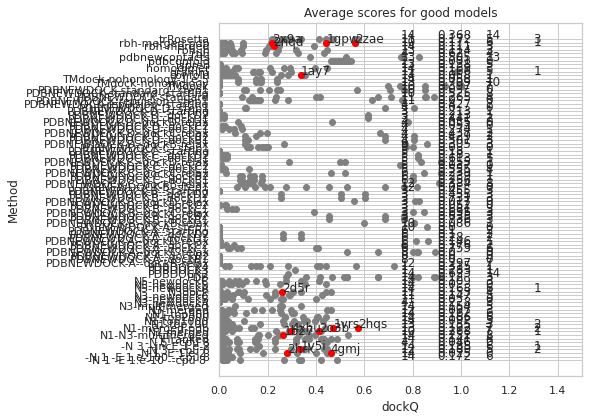

In [97]:
r = re.compile("^PDB.*|^TMd.*|^gramm|trRosetta|^pdb.*")
excludecolumns = list(filter(r.match, datasets)) # Read Note
print (excludecolumns)
includeTR=["pdbcontacts","PDBDOCK","TMdock-double"]
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best methods")

new_df=df.loc[(df.dockQ>cutoff) & (~df.JHparams.isin(excludecolumns))].sort_values('dockQ', ascending=False).drop_duplicates(["code"]).reset_index()
codes=new_df.CODE.unique()
#print(new_df)
#newdf.sort_values(["JHparams","dockQ","code"],inplace=True)

tempdf=df_max.loc[(df_max.CODE.isin(codes)) & (~df_max.params.isin(includeTR))].reset_index()
plt.scatter(tempdf.dockQ,tempdf.params,color="grey")
#print(tempdf[tempdf.params=="N1-top1000"])
plt.scatter(new_df.dockQ,new_df.params,color="red")
#print(new_df[new_df.params=="N1-top1000"])

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Average scores for good models")
ax.set_xlabel("dockQ")
ax.set_ylabel("Method")
ax.set(xlim=[0,1])
done={}
average={}
length={}
ax.set(xlim=[0,1.5])
for d in datasets: #~df.JHparams.isin(excludecolumns).unique():
    done[d]=0
    average[d]=df_max.loc[(df_max.CODE.isin(codes)) & (df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[(df_max.CODE.isin(codes)) & (df_max.params==d)]["dockQ"])
for i, txt in enumerate(tempdf.name):
    #print (i,txt, newdf.JHparams[i])
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(tempdf.loc[(tempdf.params==tempdf.params[i])&(tempdf.dockQ>cutoff)])
    
    #print (numhit,newdf.JHparams[i])
    if done[tempdf.params[i]]==0:
        done[tempdf.params[i]]=1
        ax.annotate(str(numhit),(1.1, tempdf.params[i]))
        #ax.annotate("0",(.1, tempdf.JHparams[i]))  
        ax.annotate(str(round(average[tempdf.params[i]],3)),(.9, tempdf.params[i]))          
        ax.annotate(str(round(length[tempdf.params[i]],3)),(.75, tempdf.params[i]))  
for d in datasets: #~df.JHparams.isin(excludecolumns).unique():
    done[d]=0
for i, txt in enumerate(new_df.name):
    #print (i,txt,newdf.dockQ[i], newdf.JHparams[i])
    sstr=txt[0:4]
    ax.annotate(sstr, (new_df.dockQ[i], new_df.params[i]))
    numhit=len(new_df.loc[new_df.params==new_df.params[i]])
    #numhit2=len(tempdf.loc[tempdf.JHparams==tempdf.params[i]])
    #print (numhit,newdf.JHparams[i])
    if done[new_df.params[i]]==0:
        done[new_df.params[i]]=1
        ax.annotate(str(numhit),(1.3, new_df.params[i]))  
        #ax.annotate(str(numhit2),(-0.1, new_df.JHparams[i]))


In [98]:
cutoff=0.1

In [99]:
JHsets=['-N 3 --cpu 8', 
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500',  '-N 5 --cpu 8']

cutoff=0.1

In [100]:
goodmodels=df_max.loc[(df_max.dockQ>cutoff)&(df_max.params.isin(JHsets)) ]["CODE"].unique()

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


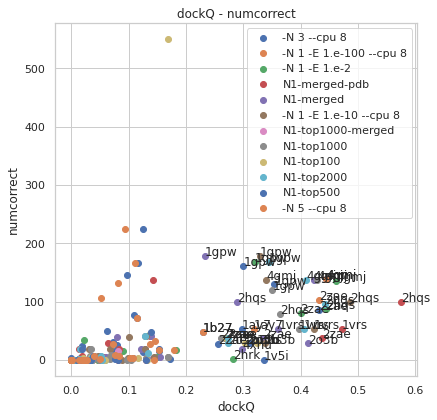

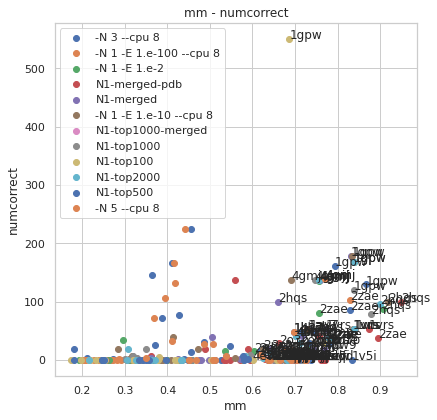

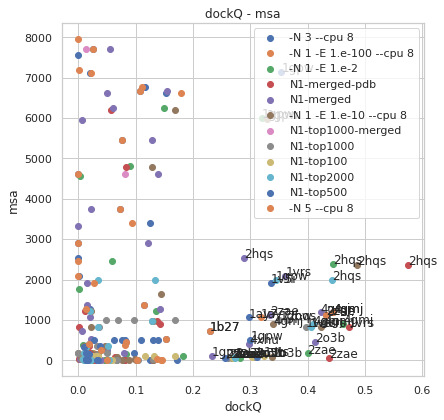

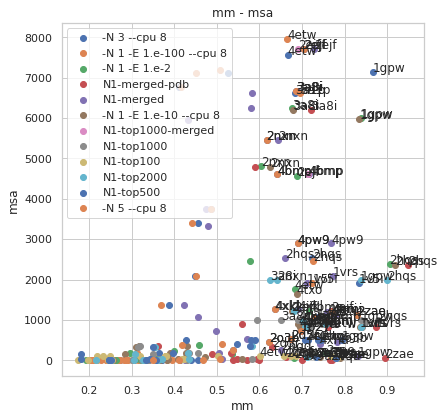

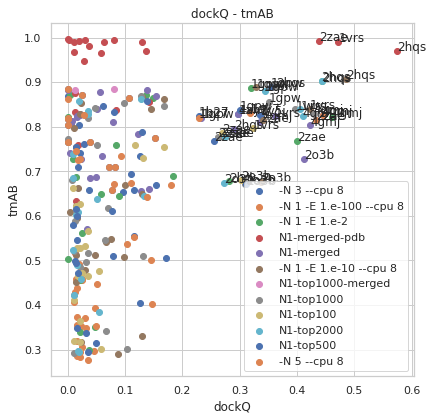

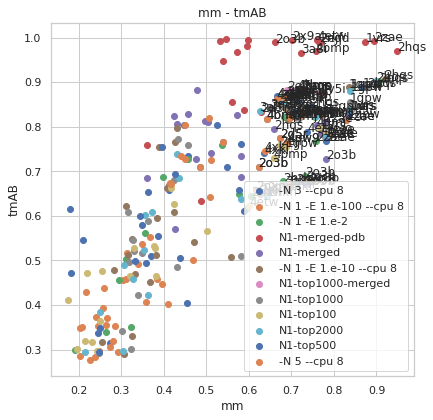

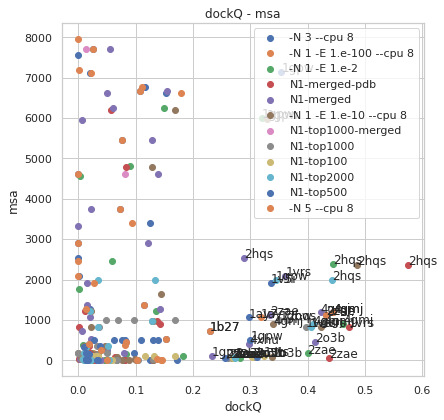

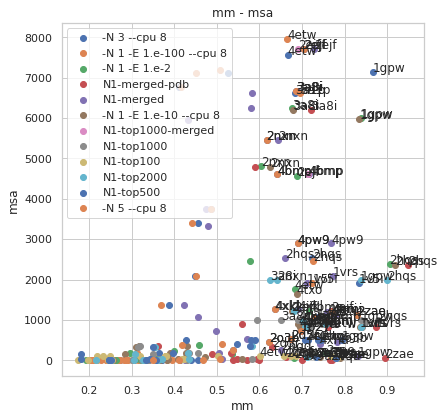

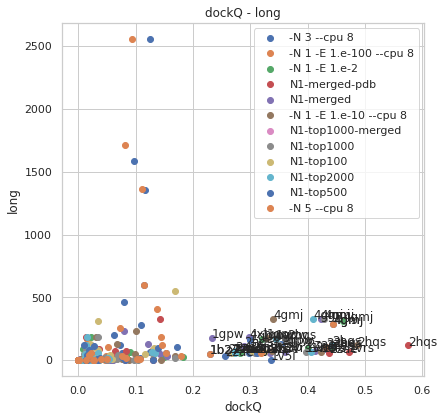

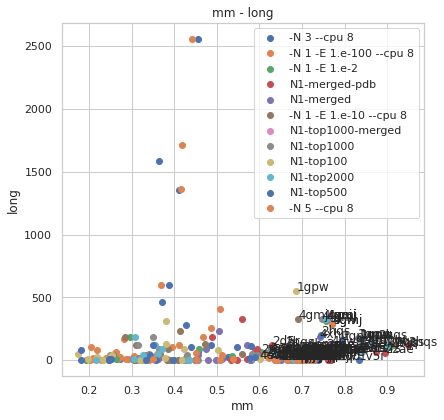

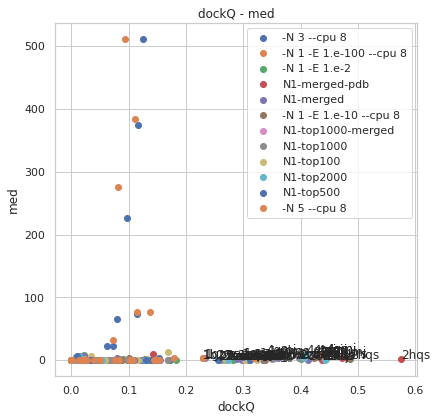

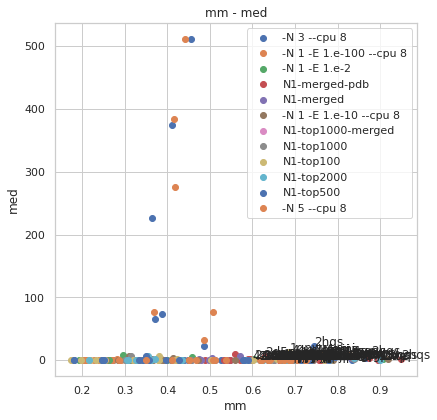

In [101]:
tempdf=df_max.loc[df_max.params.isin(JHsets)] 


tempdf=tempdf.loc[tempdf.CODE.isin(goodmodels)]
cf={"dockQ":0.2,"mm":0.6,"numcorrect":50}
for y in ["numcorrect","msa","tmAB","msa","long","med"]:
    for x in ["dockQ","mm","numcorrect"]:
        cutoff=cf[x]
        #print (Name)
         #if (Name != "lenA"):
        #    continue
        f, ax = plt.subplots(figsize=(6.5, 6.5))
        for d in JHsets:
            xdata=tempdf.loc[tempdf.params==d][x]
            ydata=tempdf.loc[tempdf.params==d][y]
            plt.scatter(xdata,ydata,label=d)
            cc=np.corrcoef(xdata,ydata)
            for i, txt in enumerate(tempdf.loc[tempdf.params==d].name):
                sstr=txt[0:4]
                if (xdata[i]>cutoff):
                    ax.annotate(sstr, (xdata[i], ydata[i]))
        ax.set_title(x + " - " + y )
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.legend()
    plt.close()

In [102]:
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', 'N1-N3-multimerged', '-N 1 -E 1.e-10 --cpu 8 ',
       'N1-top1000-merged', 'N1-top1000', 'N1-top100', 'N1-top2000',
       'N1-top500', 'N3dock', '-N 3 --incE 1.e-2', 'N3-merged',
       'N3-multimerged', 'N3-newdockA', 'N3-newdockB', 'N3-newdockC',
       'N5-newdockA', 'N5-newdockB', 'N5-newdockC', '-N 5 --cpu 8',
       'pdbconfold', 'pdbcontacts', 'PDBDOCK2', 'PDBDOCK3', 'PDBDOCK4',
       'PDBDOCK', 'PDBNEWDOCK-standard', 'PDBNEWDOCK-standard--starting',
       'PDBNEWDOCK-standard--step1', 'pdbnewcontacts',
       'PDBNEWDOCK-A--dockB1', 'PDBNEWDOCK-A--dockB2',
       'PDBNEWDOCK-A--dockB-relax', 'PDBNEWDOCK-A--dockC1',
       'PDBNEWDOCK-A--dockC2', 'PDBNEWDOCK-A--dockC-relax',
       'PDBNEWDOCK-A--dockD1', 'PDBNEWDOCK-A--dockD2',
       'PDBNEWDOCK-A--dockD-relax', 'PDBNEWDOCK-A--starting',
       'PDBNEWDOCK-A--step1', 'PD

In [103]:
goodmodels

array(['1gpw', '1vrs', '2hqs', '2nxn', '2o3b', '2zae', '3a8i', '3fpu',
       '4bmp', '4c6t', '4gmj', '4txo', '2hrk', '1ay7', '1b27', '1gcq',
       '1v5i', '2d5r', '2wbw', '2x9a', '3a1p', '3f1p', '4xs0', '3pv6',
       '5cra', '4pw9', '4xhu', '4xkl', '2nqd', '2ejf', '4etw'],
      dtype=object)

In [104]:
tempdf=df_max.loc[df_max.CODE.isin(codes)&(df_max.params.isin(pdbset))]
tempdf

name  lenA  lenB     msa     msaA  \
JHparams    code                                                               
PDB         1ay7  1ay7_u2_A-1ay7_u1_A.pdb-step1    97    97  1060.0   1485.0   
            1b27  1b27_u2_A-1b27_u1_A.pdb-step1   109   109   733.0   1484.0   
            1gpw  1gpw_u1_A-1gpw_u2_A.pdb-step1   252   204  7137.0  58466.0   
            1v5i  1v5i_u2_A-1v5i_u1_A.pdb-step1   276   276     0.0      0.0   
            1vrs  1vrs_u2_A-1vrs_u1_A.pdb-step1   124   124     0.0      0.0   
...                                         ...   ...   ...     ...      ...   
pdbcontacts 2o3b            2o3b_u1_A-2o3b_u2_A   240   144   456.0   5431.0   
            2x9a            2x9a_u1_A-2x9a_u2_A   103    63     4.0   2604.0   
            2zae            2zae_u1_A-2zae_u2_A   107    93  1125.0   1659.0   
            4gmj            4gmj_u1_A-4gmj_u2_A   253   236  1189.0   6152.0   
            4xhu            4xhu_u2_A-4xhu_u1_A   352   352   410.0   8381.0   

                     msaB   cdhit  dockQ   fnat     iRMS  ...  CODE  \
JHparams    code                                          ...         
PDB         1ay7   2034.0   986.0  0.892  0.861  185.585  ...  1ay7   
            1b27   2034.0   654.0  0.919  0.800  204.850  ...  1b27   
            1gpw  67629.0  5348.0  0.656  0.667  479.285  ...  1gpw   
            1v5i      0.0     0.0  0.357  0.340  479.679  ...  1v5i   
            1vrs      0.0     0.0  0.276  0.755  206.013  ...  1vrs   
...                   ...     ...    ...    ...      ...  ...   ...   
pdbcontacts 2o3b    518.0   306.0  0.529  0.722    2.773  ...  2o3b   
            2x9a     18.0     4.0  0.692  0.750    0.814  ...  2x9a   
            2zae   1521.0   839.0  0.539  0.565    1.397  ...  2zae   
            4gmj   1646.0   523.0  0.275  0.488    2.149  ...  4gmj   
            4xhu   8381.0   240.0  0.467  0.519   10.946  ...  4xhu   

                       params      tmAB    msaAB  tmAB_max  msaAB_max  \
JHparams    code                                                        
PDB         1ay7          PDB  0.998225   1759.5   0.99846     2034.0   
            1b27          PDB  0.998015   1759.0   0.99893     2034.0   
            1gpw          PDB  0.974965  63047.5   0.98386    67629.0   
            1v5i          PDB  0.791080      0.0   0.94285        0.0   
            1vrs          PDB  0.954805      0.0   0.99533        0.0   
...                       ...       ...      ...       ...        ...   
pdbcontacts 2o3b  pdbcontacts  0.836740   2974.5   0.93597     5431.0   
            2x9a  pdbcontacts  0.911500   1311.0   0.98016     2604.0   
            2zae  pdbcontacts  0.860355   1590.0   0.93809     1659.0   
            4gmj  pdbcontacts  0.720295   3899.0   0.72888     6152.0   
            4xhu  pdbcontacts  0.873565   4344.0   0.92326     8381.0   

                  tmAB_min  msaAB_min  numcorrect  len  
JHparams    code                                        
PDB         1ay7   0.99799     1485.0         0.0  187  
            1b27   0.99710     1484.0         0.0  199  
            1gpw   0.96709    58466.0         0.0  456  
            1v5i   0.63931        0.0         0.0  354  
            1vrs   0.91428        0.0         0.0  241  
...                    ...        ...         ...  ...  
pdbcontacts 2o3b   0.73751      518.0         0.0  384  
            2x9a   0.84284       18.0         0.0  166  
            2zae   0.78262     1521.0         0.0  200  
            4gmj   0.71171     1646.0         0.0  489  
            4xhu   0.85175      307.0         0.0  447  

[95 rows x 51 columns]

In [105]:
df_max.loc[df_max.params=="N3-multimerged"]["dockQ"]

JHparams        code
N3-multimerged  1ay7    0.337
                1b27    0.250
                1bdj    0.000
                1buh    0.000
                1bvn    0.010
                1cc0    0.000
                1clv    0.014
                1dfj    0.022
                1eay    0.001
                1eer    0.000
                1ewy    0.012
                1fle    0.001
                1fq1    0.112
                1g6v    0.000
                1g73    0.000
                1gcq    0.128
                1gpw    0.258
                1he1    0.075
                1i4e    0.012
                1i8l    0.005
                1jiw    0.011
                1k5g    0.000
                1nql    0.003
                2ido    0.018
                2nqd    0.067
Name: dockQ, dtype: float64

-N 3 --cpu 8
N1-N3-multimerged
N1-merged
N1-merged-pdb
N1-top1000
N3-merged
N3-multimerged


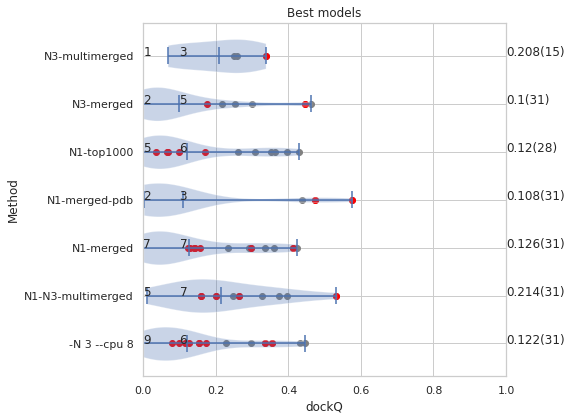

In [133]:
pdbset=['-N 3 --cpu 8',  'N1-top1000',
        'N1-merged','N1-merged-pdb','N3-merged',"N3-multimerged","N1-N3-multimerged"]
cutoff=0.2
codes=goodmodels
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
#tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]
tempdf=df_max.loc[df_max.CODE.isin(codes)&(df_max.params.isin(pdbset))]
#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['CODE']).reset_index()
best_df.sort_values("params")

#good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
good_df=df_max.loc[df_max.CODE.isin(codes)&(df_max.params.isin(pdbset))&(df_max.dockQ>cutoff )].reset_index()

plt.scatter(good_df.dockQ,good_df.params,color="grey")
plt.scatter(best_df.dockQ,best_df.params,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.params==best_df.params[i]])
    #print (numhit,newdf.params[i])
    if done[best_df.params[i]]==0:
        done[best_df.params[i]]=1
        ax.annotate(str(numhit),(.0, best_df.params[i]))
        ax.annotate(str(round(average[best_df.params[i]],3))+"("+str(length[good_df.params[i]])+")"
                    ,(1.0, best_df.params[i]))
for d in pdbset:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.params[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.params[i]])
    #print (numhit,newdf.params[i])
    if done[good_df.params[i]]==0:
        done[good_df.params[i]]=1
        ax.annotate(str(numhit),(.1, good_df.params[i]))
        #ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        #ax.annotate("("+str(length[good_df.JHparams[i]])+")",(1.2, good_df.JHparams[i]))


Text(0, 0.5, 'dockQ')

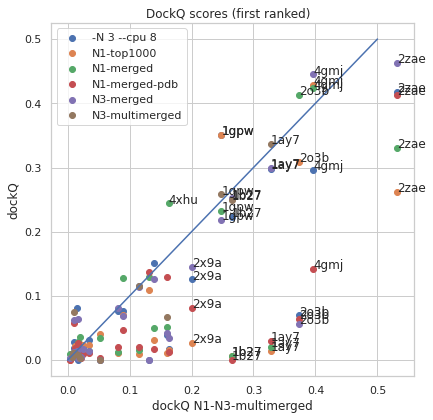

In [134]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
baseset="N1-N3-multimerged"
for d in pdbset:
  
    if d==baseset:continue   
    #print (d)
    df_merged = pd.merge(data_first[baseset],data_first[d], on=['CODE'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.5]
y=[0,0.5]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first ranked)  ")
ax.set_xlabel("dockQ "+baseset)
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

No handles with labels found to put in legend.


Text(0, 0.5, 'dockQ')

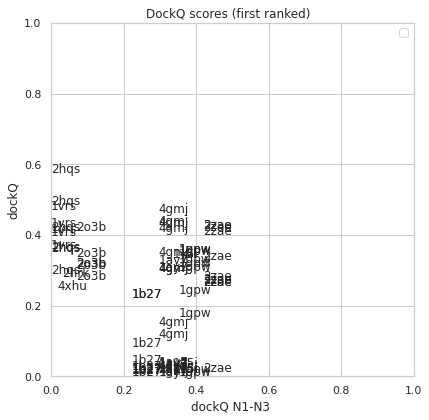

In [108]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in JHsets:
  
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first[datasets[0]],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    #plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
#x=[0,0.3]
#y=[0,0.3]
#plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first ranked)  ")
ax.set_xlabel("dockQ N1-N3 ")
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [109]:
goodmodels

array(['1gpw', '1vrs', '2hqs', '2nxn', '2o3b', '2zae', '3a8i', '3fpu',
       '4bmp', '4c6t', '4gmj', '4txo', '2hrk', '1ay7', '1b27', '1gcq',
       '1v5i', '2d5r', '2wbw', '2x9a', '3a1p', '3f1p', '4xs0', '3pv6',
       '5cra', '4pw9', '4xhu', '4xkl', '2nqd', '2ejf', '4etw'],
      dtype=object)

In [110]:
JHsets

['-N 3 --cpu 8',
 '-N 1 -E 1.e-100 --cpu 8',
 '-N 1 -E 1.e-2 ',
 'N1-merged-pdb',
 'N1-merged',
 '-N 1 -E 1.e-10 --cpu 8 ',
 'N1-top1000-merged',
 'N1-top1000',
 'N1-top100',
 'N1-top2000',
 'N1-top500',
 '-N 5 --cpu 8']

In [111]:
JHsets1=['-N 3 --cpu 8',
 '-N 1 -E 1.e-100 --cpu 8',
 '-N 1 -E 1.e-2 ',
 'N1-merged-pdb',
 'N1-merged',
 '-N 1 -E 1.e-10 --cpu 8 ']

In [112]:
JHsets2=[
 'N1-top1000-merged',
 'N1-top1000',
 'N1-top100',
 'N1-top2000',
 'N1-top500',
 '-N 5 --cpu 8']

In [113]:
JHsets=['-N 3 --cpu 8',
 '-N 1 -E 1.e-2 --cpu 8',
 '-N 1 -E 1.e-10 --cpu 8 ',
 '-N 5 --cpu 8']
good_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets))].reset_index()


In [114]:
train_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets1))].reset_index()
test_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets2))].reset_index()

In [115]:
good_df=df_first.loc[(df_first.code.isin(goodmodels)&(df_first.JHparams.isin(JHsets)))].reset_index()

In [116]:
good_df=df_first.loc[(df_first.JHparams.isin(JHsets))].reset_index()

In [117]:
good_df

index                 name      JHparams lenA lenB   msa    msaA    msaB  \
0        0  1ay7_u1_A-1ay7_u2_A  -N 3 --cpu 8   97   90  1060    1485    2034   
1        2  1b27_u1_A-1b27_u2_A  -N 3 --cpu 8  109   90   733    1484    2034   
2        4  1bdj_u1_A-1bdj_u2_A  -N 3 --cpu 8  129  118  5651  349880   23051   
3        6  1buh_u1_A-1buh_u2_A  -N 3 --cpu 8  291   72  1177  555226    1820   
4        8  1bvn_u1_A-1bvn_u2_A  -N 3 --cpu 8  496   75    95   52623     123   
..     ...                  ...           ...  ...  ...   ...     ...     ...   
648   6259  4zfr_u1_A-4zfr_u2_A  -N 5 --cpu 8  186   77  1358   14421   42037   
649   6261  5brr_u1_A-5brr_u2_A  -N 5 --cpu 8  378  266   611   13523   45636   
650   6263  5cec_u1_A-5cec_u2_A  -N 5 --cpu 8  403  191  1594   33067  312612   
651   6265  5cra_u1_A-5cra_u2_A  -N 5 --cpu 8  193   77     1      11   42026   
652   6267  5eg3_u1_A-5eg3_u2_A  -N 5 --cpu 8  303  105   499  560629   26558   

    cdhit  dockQ  ...  CODE        params      tmAB     msaAB tmAB_max  \
0    1026  0.298  ...  1ay7  -N 3 --cpu 8  0.828190    1759.5  0.84625   
1     654  0.223  ...  1b27  -N 3 --cpu 8  0.824750    1759.0  0.85428   
2    5071      0  ...  1bdj  -N 3 --cpu 8  0.861435  186465.5  0.92240   
3     548      0  ...  1buh  -N 3 --cpu 8  0.560760  278523.0  0.73259   
4      85  0.006  ...  1bvn  -N 3 --cpu 8  0.619740   26373.0  0.70905   
..    ...    ...  ...   ...           ...       ...       ...      ...   
648   490      0  ...  4zfr  -N 5 --cpu 8  0.796765   28229.0  0.83034   
649   550   0.02  ...  5brr  -N 5 --cpu 8  0.790865   29579.5  0.80934   
650  1577      0  ...  5cec  -N 5 --cpu 8  0.628690  172839.5  0.85640   
651     1  0.008  ...  5cra  -N 5 --cpu 8  0.536735   21018.5  0.71605   
652   278      0  ...  5eg3  -N 5 --cpu 8  0.733390  293593.5  0.77821   

    msaAB_max tmAB_min msaAB_min numcorrect  len  
0      2034.0  0.81013    1485.0     53.985  187  
1      2034.0  0.79522    1484.0     49.025  199  
2    349880.0  0.80047   23051.0          0  247  
3    555226.0  0.38893    1820.0          0  363  
4     52623.0  0.53043     123.0          0  571  
..        ...      ...       ...        ...  ...  
648   42037.0  0.76319   14421.0          0  263  
649   45636.0  0.77239   13523.0          2  644  
650  312612.0  0.40098   33067.0          0  594  
651   42026.0  0.35742      11.0          0  270  
652  560629.0  0.68857   26558.0          0  408  

[653 rows x 54 columns]

In [118]:
cutoff

0.2

AttributeError: 'float' object has no attribute 'shape'

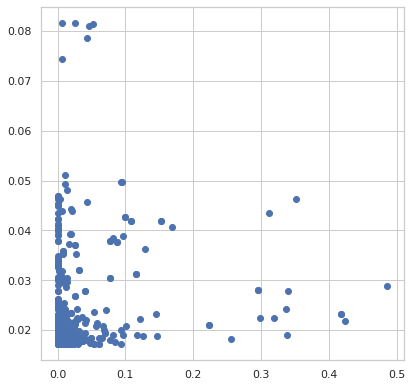

AttributeError: 'float' object has no attribute 'shape'

In [119]:
ydata=good_df.dockQ
cols=["lenA","lenB","msa","long","med","longA","medA","longB","medB","tmA","tmB"]

#xdata=good_df[["lenA","lenB","long","med"]]
#cols=["longA","longB","medA","medB","tmA","tmB"]
cols=["med","long","msa"]
#cols=["msa"]
xdata=good_df[cols]


reg.fit(xdata,ydata)
ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
cc=np.corrcoef(ydata,ypred)
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")
(i,j,dockq,mm)=get_ranks(good_df,ypred)
#print(i,j,k/i)
ax.set_title("CC" + " " + str(round(cc[0,1],3))
            + " Good: " + str(round(j/i,3)) + " Loss: " + str(round(dockq/i,3))
             + " , " + str(round(mm/i,3))
             + " Test: " + str(i)
            )


In [120]:
print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

Intercept: 
 0.017188129388486757
Coefficients: 
 [-9.49693169e-05  2.68328604e-05  3.65236554e-06]


In [121]:

for s in JHsets:
    set_df=good_df.loc[good_df.params==s]
    ypred=set_df["dockQ"].to_list()
    (i,j,dockq,mm)=get_ranks(set_df,ypred)
    print (s,i,j,dockq,mm)

-N 3 --cpu 8 6 6 0.0 0.0
-N 1 -E 1.e-2 --cpu 8 0 0 0 0
-N 1 -E 1.e-10 --cpu 8 

 6 6 0.0 0.0
-N 5 --cpu 8 4 4 0.0 0.0


AttributeError: 'float' object has no attribute 'shape'

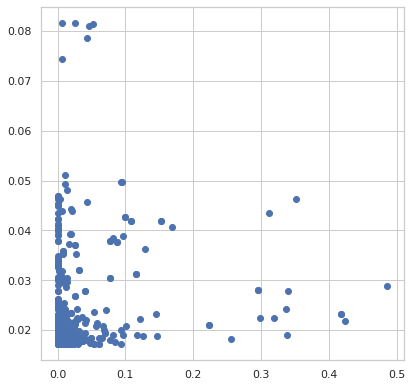

AttributeError: 'float' object has no attribute 'shape'

In [122]:
xdata=good_df[cols]
ydata=good_df.dockQ

ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
cc=np.corrcoef(ydata,ypred)
ax.set_title("CC" + " " + str(cc[0,1]))
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")


In [123]:
good_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets))].reset_index()
good_df

index                 name      JHparams lenA lenB   msa    msaA    msaB  \
0       0  1ay7_u1_A-1ay7_u2_A  -N 3 --cpu 8   97   90  1060    1485    2034   
1       2  1b27_u1_A-1b27_u2_A  -N 3 --cpu 8  109   90   733    1484    2034   
2      30  1gcq_u1_A-1gcq_u2_A  -N 3 --cpu 8   66   57  1365   77497   77704   
3      34  1gpw_u1_A-1gpw_u2_A  -N 3 --cpu 8  252  204  7137   58466   67629   
4      86  1v5i_u1_A-1v5i_u2_A  -N 3 --cpu 8  276   78  1922   54177   12066   
..    ...                  ...           ...  ...  ...   ...     ...     ...   
88   6233  4txo_u1_A-4txo_u2_A  -N 5 --cpu 8  178  158  7106  131653  115265   
89   6243  4xhu_u1_A-4xhu_u2_A  -N 5 --cpu 8  352   95   410    9970     548   
90   6245  4xkl_u1_A-4xkl_u2_A  -N 5 --cpu 8   76   34  1262   41752  442180   
91   6249  4xs0_u1_A-4xs0_u2_A  -N 5 --cpu 8  147  141  3395    9453    9375   
92   6265  5cra_u1_A-5cra_u2_A  -N 5 --cpu 8  193   77     1      11   42026   

   cdhit  dockQ  ...  CODE        params      tmAB     msaAB tmAB_max  \
0   1026  0.298  ...  1ay7  -N 3 --cpu 8  0.828190    1759.5  0.84625   
1    654  0.223  ...  1b27  -N 3 --cpu 8  0.824750    1759.0  0.85428   
2    765  0.115  ...  1gcq  -N 3 --cpu 8  0.539990   77600.5  0.63426   
3   5348  0.351  ...  1gpw  -N 3 --cpu 8  0.885175   63047.5  0.89229   
4   1642  0.336  ...  1v5i  -N 3 --cpu 8  0.818890   33121.5  0.88557   
..   ...    ...  ...   ...           ...       ...       ...      ...   
88  6529  0.022  ...  4txo  -N 5 --cpu 8  0.725480  123459.0  0.74765   
89   240  0.018  ...  4xhu  -N 5 --cpu 8  0.678145    5259.0  0.73972   
90   355  0.014  ...  4xkl  -N 5 --cpu 8  0.740180  241966.0  0.88845   
91  2649  0.094  ...  4xs0  -N 5 --cpu 8  0.732555    9414.0  0.74440   
92     1  0.008  ...  5cra  -N 5 --cpu 8  0.536735   21018.5  0.71605   

   msaAB_max tmAB_min msaAB_min numcorrect  len  
0     2034.0  0.81013    1485.0     53.985  187  
1     2034.0  0.79522    1484.0     49.025  199  
2    77704.0  0.44572   77497.0      71.76  123  
3    67629.0  0.87806   58466.0        119  456  
4    54177.0  0.75221   12066.0          1  354  
..       ...      ...       ...        ...  ...  
88  131653.0  0.70331  115265.0          1  336  
89    9970.0  0.61657     548.0          0  447  
90  442180.0  0.59191   41752.0          0  110  
91    9453.0  0.72071    9375.0    224.928  288  
92   42026.0  0.35742      11.0          0  270  

[93 rows x 54 columns]

In [124]:
# Now we try all combinations - no plots
set1_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets1))].reset_index()
set2_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets2))].reset_index()
good_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets))].reset_index()

cols=["lenA","lenB","msa","long","med","longA","medA","longB","medB","tmA","tmB"]
ydata=good_df.dockQ

res={}
maxvalue=0
for c in cols:
    xdata=good_df[[c]]
    reg.fit(xdata,ydata)
    ypred = reg.predict(xdata)
    print (c,round(np.corrcoef(ydata,ypred)[0,1],3))
    res[c]=np.corrcoef(ydata,ypred)[0,1]
    maxvalue=max(res[c],maxvalue)    
for c in cols:
    for d in cols:
        xdata=good_df[[c,d]]
        reg.fit(xdata,ydata)
        ypred = reg.predict(xdata)
        #print (c,d,round(np.corrcoef(ydata,ypred)[0,1],3))
        res[c+d]=np.corrcoef(ydata,ypred)[0,1]
        #if (res[c+d]-maxvalue>0.0):
        #    print (c,d,round(np.corrcoef(ydata,ypred)[0,1],3))
        (i,j,k,l)=get_ranks(good_df,ypred)
        print (c,d,i,j,k,l)

AttributeError: 'float' object has no attribute 'shape'

In [125]:

print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)


Intercept: 
 0.12319261779318291
Coefficients: 
 [-0.00012616]


Text(0, 0.5, 'predicted dockQ')

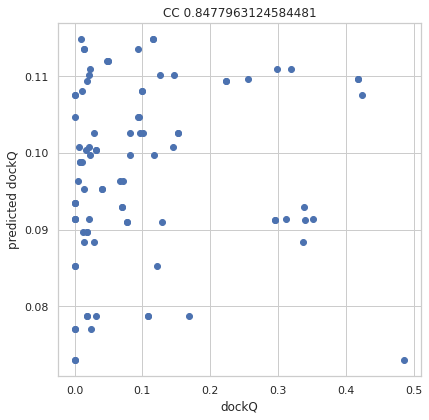

In [126]:
ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
#cc=np.corrcoef(ydata,ypred)
ax.set_title("CC" + " " + str(cc[0,1]))
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")


In [127]:
newdf=df.loc[df.JHparams=="trRosetta"]
plt.scatter(newdf.csv,newdf.)

SyntaxError: invalid syntax (<ipython-input-127-1bbe5c8e123e>, line 2)

In [128]:
newdf[["CODE","dockQ","csv","tmAB","long"]].sort_values("csv")

KeyError: "['csv'] not in index"

In [129]:
JHsets=['-N 3 --cpu 8', 
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500',  '-N 5 --cpu 8']


Text(0.5, 0, 'cdhit')

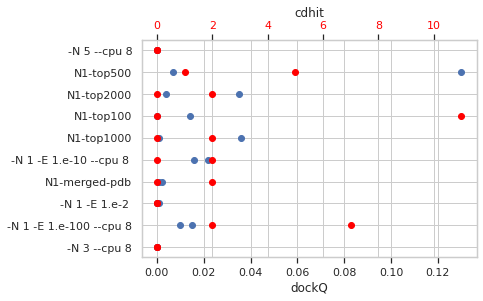

In [130]:
newdf=df.loc[(df.CODE=="4etw")&(df.JHparams.isin(JHsets))].reset_index()
fig, ax1 = plt.subplots()
ax1.set_xlabel('dockQ')
ax1.scatter(newdf.dockQ,newdf.JHparams)
ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
ax2.scatter(newdf.long,newdf.JHparams,color="red")
ax2.tick_params(axis='x', labelcolor="red")
ax2.set_xlabel('cdhit')

Text(0.5, 0, 'cdhit')

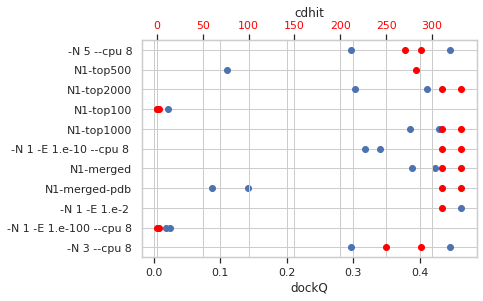

In [131]:
newdf=df.loc[(df.CODE=="4gmj")&(df.JHparams.isin(JHsets))].reset_index()
fig, ax1 = plt.subplots()
ax1.set_xlabel('dockQ')
ax1.scatter(newdf.dockQ,newdf.JHparams)
ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
ax2.scatter(newdf.long,newdf.JHparams,color="red")
ax2.tick_params(axis='x', labelcolor="red")
ax2.set_xlabel('cdhit')

# bes models to test 2zae 4gmj
# Bad model 4etw

In [132]:
df_max.loc[(df_max.params=="trRosetta") & (df_max.dockQ==0)]

name  lenA  lenB     msa      msaA      msaB  \
JHparams  code                                                                
trRosetta 3fap  3fap_u2_A-3fap_u1_A   108   108  1208.0   35975.0   35975.0   
          3l1z  3l1z_u2_A-3l1z_u1_A   153   153  1390.0  136672.0  136672.0   
          3rj3  3rj3_u2_A-3rj3_u1_A   295   295   359.0   55937.0   55937.0   
          4emj  4emj_u2_A-4emj_u1_A   403   403  6589.0  354953.0  354953.0   

                 cdhit  dockQ  fnat     iRMS  ...  CODE     params      tmAB  \
JHparams  code                                ...                              
trRosetta 3fap   573.0    0.0   0.0  187.525  ...  3fap  trRosetta  0.840125   
          3l1z   830.0    0.0   0.0  261.906  ...  3l1z  trRosetta  0.776680   
          3rj3   247.0    0.0   0.0  515.213  ...  3rj3  trRosetta  0.635370   
          4emj  5681.0    0.0   0.0  687.538  ...  4emj  trRosetta  0.884110   

                   msaAB  tmAB_max  msaAB_max  tmAB_min  msaAB_min  \
JHparams  code                                                       
trRosetta 3fap   18731.0   0.87845    35975.0   0.80207     1489.0   
          3l1z   87194.0   0.83424   136672.0   0.72778    37864.0   
          3rj3   39722.5   0.80210    55937.0   0.48427    23508.0   
          4emj  195361.5   0.90839   354953.0   0.86736    35929.0   

                numcorrect  len  
JHparams  code                   
trRosetta 3fap         0.0  201  
          3l1z         0.0  239  
          3rj3         0.0  421  
          4emj         0.0  509  

[4 rows x 51 columns]